In [1]:
!pip install category_encoders

     |████████████████████████████████| 81kB 3.6MB/s 


In [2]:
!pip install catboost

     |████████████████████████████████| 67.3MB 54kB/s 


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split as tts, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, accuracy_score
from lightgbm.sklearn import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor 
from category_encoders.basen import BaseNEncoder
from catboost import CatBoostRegressor

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Training dataset

In [4]:
missing_values = ["n/a", "na", "--", "NONE", "None", "none", "NA", "N/A",'inf','-inf', '?', 'Null', 'NULL']
train_data = pd.read_csv('garments_worker_productivity.csv', na_values = missing_values)
train_data.head()

date   quarter  ... no_of_workers actual_productivity
0  1/1/2015  Quarter1  ...          59.0            0.940725
1  1/1/2015  Quarter1  ...           8.0            0.886500
2  1/1/2015  Quarter1  ...          30.5            0.800570
3  1/1/2015  Quarter1  ...          30.5            0.800570
4  1/1/2015  Quarter1  ...          56.0            0.800382

[5 rows x 15 columns]

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   1197 non-null   object 
 1   quarter                1197 non-null   object 
 2   department             1197 non-null   object 
 3   day                    1197 non-null   object 
 4   team                   1197 non-null   int64  
 5   targeted_productivity  1197 non-null   float64
 6   smv                    1197 non-null   float64
 7   wip                    691 non-null    float64
 8   over_time              1197 non-null   int64  
 9   incentive              1197 non-null   int64  
 10  idle_time              1197 non-null   float64
 11  idle_men               1197 non-null   int64  
 12  no_of_style_change     1197 non-null   int64  
 13  no_of_workers          1197 non-null   float64
 14  actual_productivity    1197 non-null   float64
dtypes: f

In [65]:
train_data.isnull().sum()

day                        0
quarter                    0
team                       0
targeted_productivity      0
smv                        0
wip                      506
over_time                  0
incentive                  0
idle_time                  0
idle_men                   0
no_of_style_change         0
actual_productivity        0
dtype: int64

In [6]:
print('FEATURES CORRELATION TO TARGET VALUES :')
train_data_corr = train_data[train_data.columns[0:]].corr()['actual_productivity']
print(train_data_corr)

FEATURES CORRELATION TO TARGET VALUES :
team                    -0.148753
targeted_productivity    0.421594
smv                     -0.122089
wip                      0.131147
over_time               -0.054206
incentive                0.076538
idle_time               -0.080851
idle_men                -0.181734
no_of_style_change      -0.207366
no_of_workers           -0.057991
actual_productivity      1.000000
Name: actual_productivity, dtype: float64


wip column has around 47% nulls but as I am not from this data domain, so I need to check whether this feature is important or not before deleting.

Outliers are present in columns :- smv, wip(contains NaNs), over_time, incentive, idle time, idle men, no_of_style_change. Normalization is required as skewness is also present because of outliers.


In [66]:
train_data.describe()

day      quarter  ...  no_of_style_change  actual_productivity
count  1197.000000  1197.000000  ...         1197.000000          1197.000000
mean      2.534670     1.399332  ...            0.150376             0.735091
std       1.714538     1.215535  ...            0.427848             0.174488
min       0.000000     0.000000  ...            0.000000             0.233705
25%       1.000000     0.000000  ...            0.000000             0.650307
50%       3.000000     1.000000  ...            0.000000             0.773333
75%       4.000000     2.000000  ...            0.000000             0.850253
max       5.000000     4.000000  ...            2.000000             1.120437

[8 rows x 12 columns]

Quarter is divided in 5 parts, so I can delete date column as for example if the manager is questioning a team of workers than he/she will say that your team has low productivity level in quarter 1 of the month rather than saying the exact date.

In [67]:
train_data.quarter.value_counts()

0    360
1    335
3    248
2    210
4     44
Name: quarter, dtype: int64

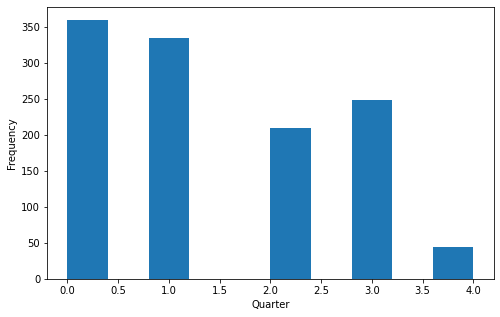

In [70]:
plt.figure(figsize=(8,5))
plt.xlabel('Quarter')
plt.ylabel('Frequency')
train_data['quarter'].plot.hist()

In [7]:
train_data.drop(['date'],1,inplace=True)

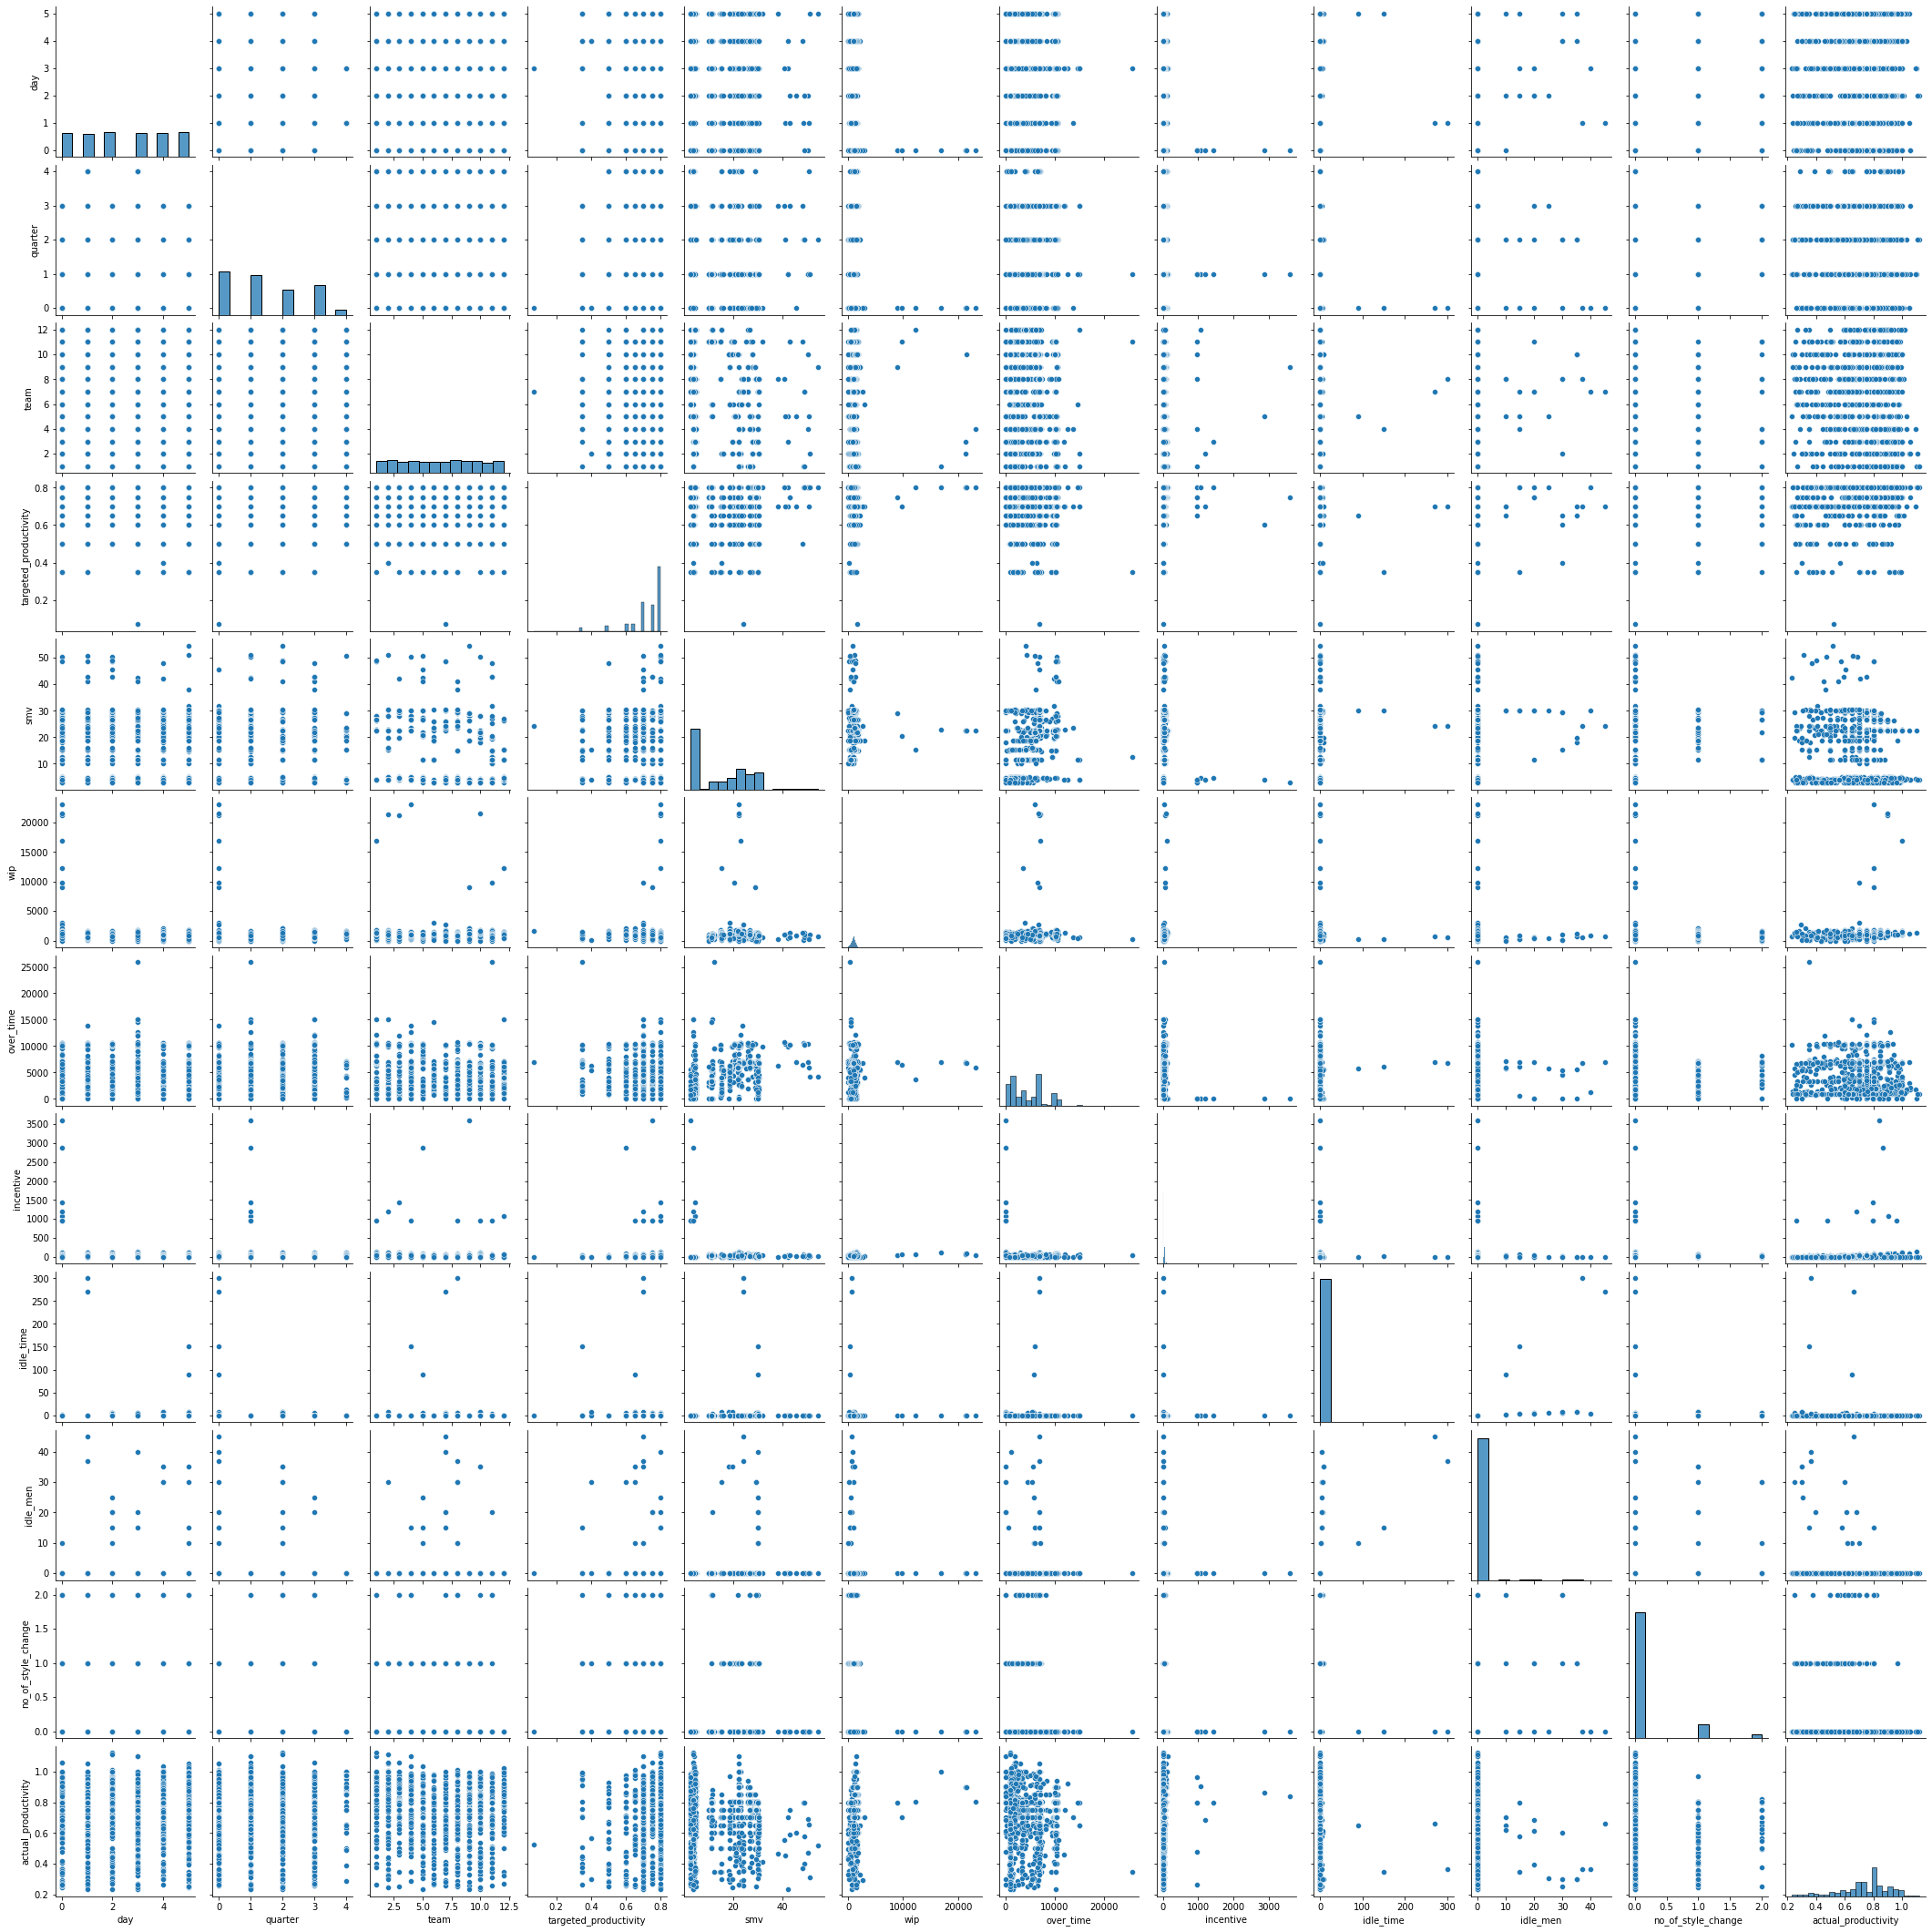

In [64]:
sns.pairplot(train_data)

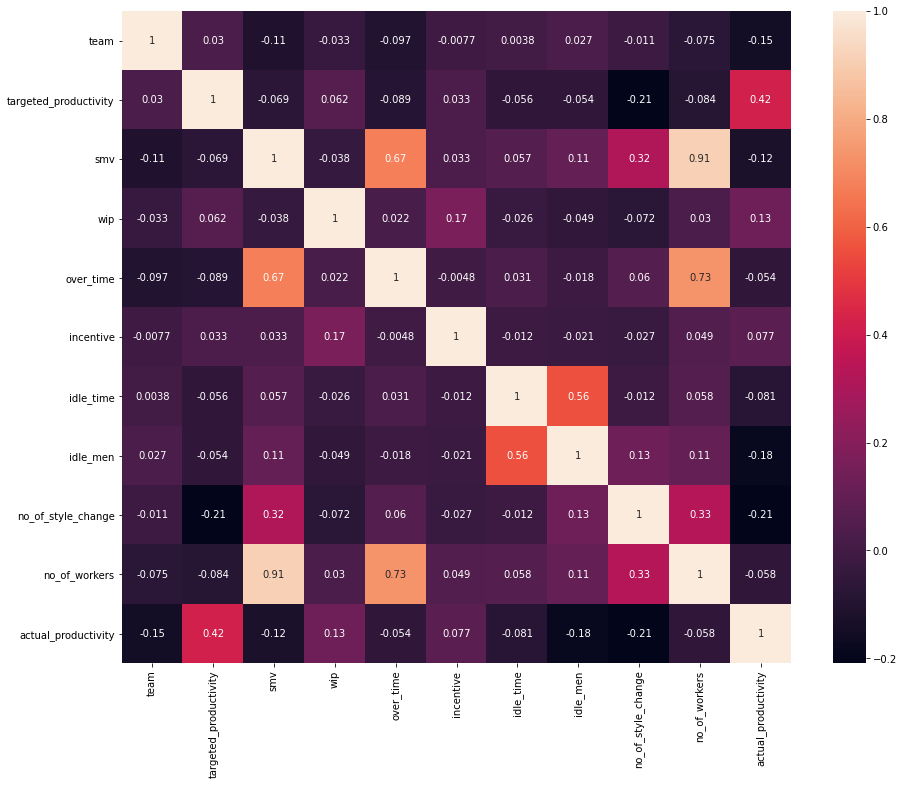

In [8]:
plt.figure(figsize=(15,12))
sns.heatmap(train_data.corr(),annot=True)

In [9]:
count = train_data['department'].map(lambda x: len(x))
count.value_counts()

6    691
9    506
Name: department, dtype: int64

I did not label encoded the department variable because it was creating a high multicollinearity with [no. of workers] and [smv]. So I used another approach.

In [10]:
to_labelencode = train_data[['day', 'quarter']]
le = LabelEncoder()
label_encoded_features = to_labelencode.apply(le.fit_transform)

In [11]:
train_data.drop(['day', 'quarter'],1,inplace=True)

train_data = label_encoded_features.join(train_data)
train_data

day  quarter  ... no_of_workers  actual_productivity
0       3        0  ...          59.0             0.940725
1       3        0  ...           8.0             0.886500
2       3        0  ...          30.5             0.800570
3       3        0  ...          30.5             0.800570
4       3        0  ...          56.0             0.800382
...   ...      ...  ...           ...                  ...
1192    5        1  ...           8.0             0.628333
1193    5        1  ...           8.0             0.625625
1194    5        1  ...           8.0             0.625625
1195    5        1  ...          15.0             0.505889
1196    5        1  ...           6.0             0.394722

[1197 rows x 14 columns]

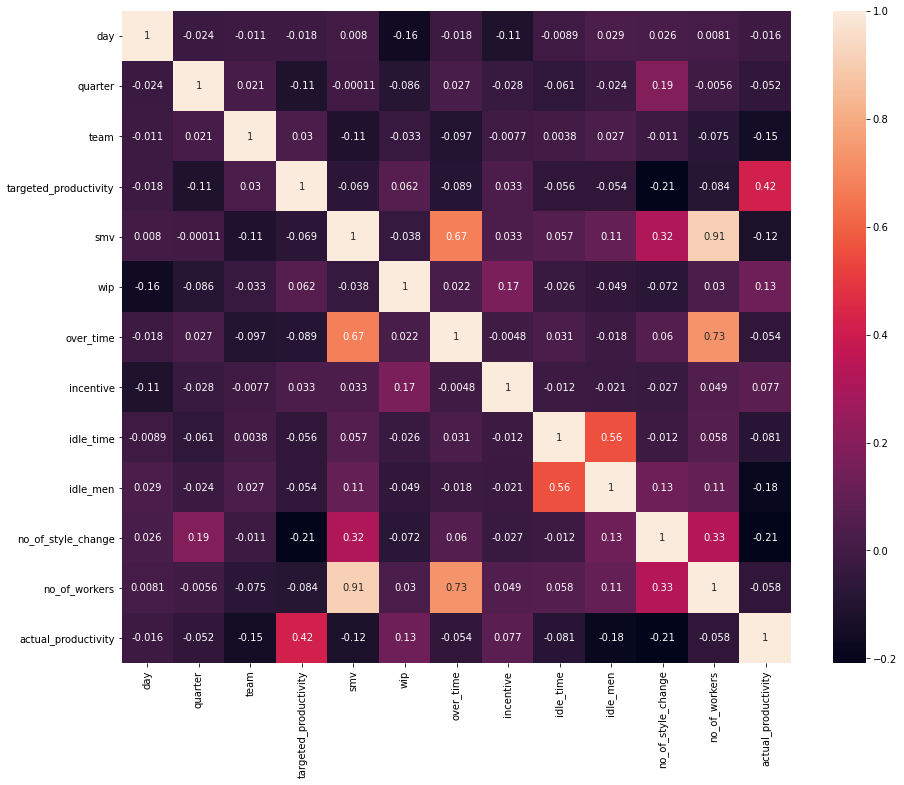

In [12]:
plt.figure(figsize=(15,12))
sns.heatmap(train_data.corr(),annot=True)

Deleting [no. of workers] as it is to reduce multicollinearity affect.

In [13]:
train_data.drop(['no_of_workers'],1,inplace=True)

This is BaseN Encoder has default base=2, which means this will work as binary encoder. We can also specifiy base = 1,3,5,10 and others too. base=1 works as one hot encoder. [BaseN encoding link](https://contrib.scikit-learn.org/category_encoders/basen.html)

In [14]:
basen = BaseNEncoder(base=2, cols = train_data[['department']], return_df=True )
basen_encoded_feature = basen.fit_transform(train_data[['department']])

# 0 = sweing & 1 = finishing
print(basen_encoded_feature)

basen_encoded_feature.drop(['department_1'],1,inplace=True)

      department_0  department_1
0                0             1
1                1             0
2                0             1
3                0             1
4                0             1
...            ...           ...
1192             1             0
1193             1             0
1194             1             0
1195             1             0
1196             1             0

[1197 rows x 2 columns]


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [15]:
train_data.drop(['department'],1,inplace=True)

In [16]:
baseN_train_data = basen_encoded_feature.join(train_data)
baseN_train_data = baseN_train_data.rename(columns={'department_0' : 'department'})

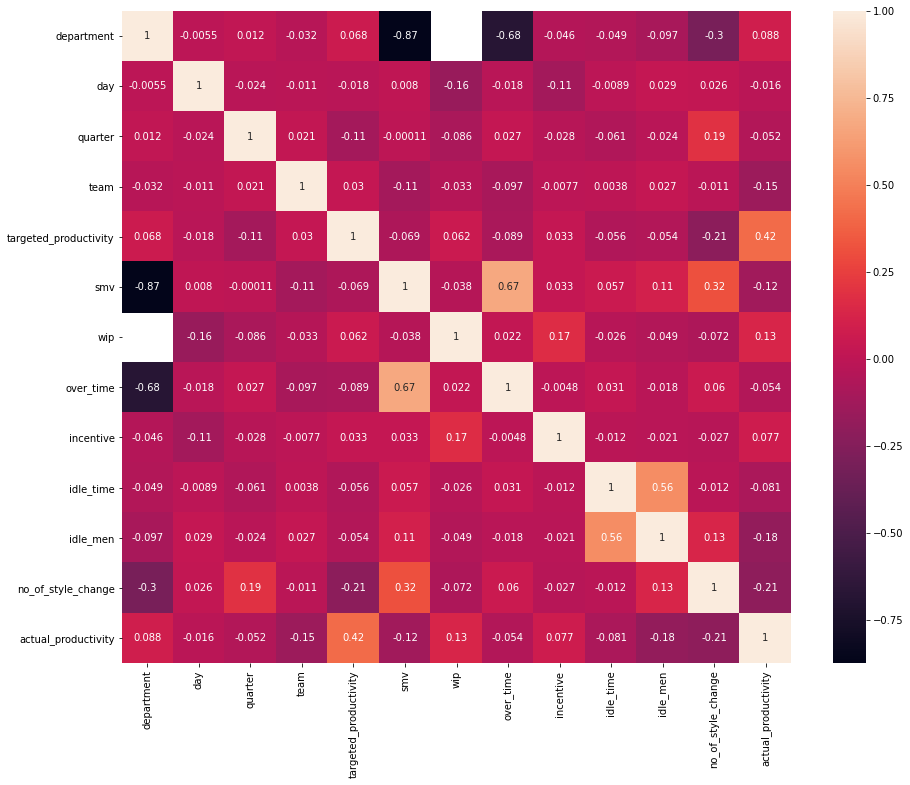

In [17]:
plt.figure(figsize=(15,12))
sns.heatmap(baseN_train_data.corr(),annot=True)

In [18]:
lr = LinearRegression()
mice_imputer = IterativeImputer(random_state=42, estimator=lr, max_iter=10, n_nearest_features=2, imputation_order = 'ascending')
cleaned_train_data = mice_imputer.fit_transform(baseN_train_data)

cleaned_train_data = pd.DataFrame(cleaned_train_data)
cleaned_train_data.columns = ['quarter', 'department', 'day  ', 'team', 'targeted_productivity',
                              'smv', 'wip', 'over_time', 'incentive', 'idle_time', 'idle_men',
                              'no_of_style_change', 'actual_productivity']
                                                        
cleaned_train_data

quarter  department  ...  no_of_style_change  actual_productivity
0         0.0         3.0  ...                 0.0             0.940725
1         1.0         3.0  ...                 0.0             0.886500
2         0.0         3.0  ...                 0.0             0.800570
3         0.0         3.0  ...                 0.0             0.800570
4         0.0         3.0  ...                 0.0             0.800382
...       ...         ...  ...                 ...                  ...
1192      1.0         5.0  ...                 0.0             0.628333
1193      1.0         5.0  ...                 0.0             0.625625
1194      1.0         5.0  ...                 0.0             0.625625
1195      1.0         5.0  ...                 0.0             0.505889
1196      1.0         5.0  ...                 0.0             0.394722

[1197 rows x 13 columns]

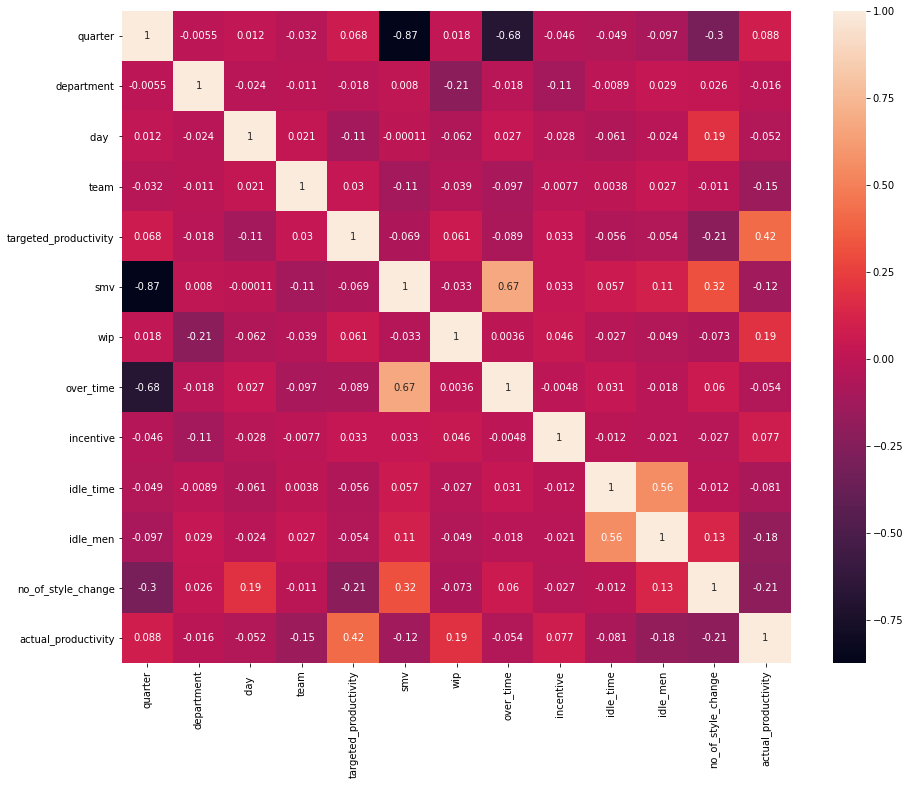

In [19]:
plt.figure(figsize=(15,12))
sns.heatmap(cleaned_train_data.corr(),annot=True)

In [20]:
cleaned_train_data.skew()

quarter                   0.313258
department               -0.029637
day                       0.386482
team                      0.009848
targeted_productivity    -2.144150
smv                       0.405937
wip                      12.033181
over_time                 0.673287
incentive                15.790746
idle_time                20.545425
idle_men                  9.855079
no_of_style_change        2.942506
actual_productivity      -0.807492
dtype: float64

I Must delete this type of columns(idle_time, idle_men) which are called as quasi constant i.e. almost constant means single value holds the most frequency. This columns can be useful in visualization when the manager wants to know the reason of interuptions in work. For prediction this are not useful.

In [21]:
cleaned_train_data['idle_men'].value_counts(), cleaned_train_data['idle_time'].value_counts() 

(0.0     1179
 20.0       3
 30.0       3
 15.0       3
 10.0       3
 35.0       2
 40.0       1
 25.0       1
 37.0       1
 45.0       1
 Name: idle_men, dtype: int64, 0.0      1179
 3.5         3
 4.0         2
 4.5         2
 8.0         2
 5.0         2
 2.0         2
 270.0       1
 150.0       1
 6.5         1
 300.0       1
 90.0        1
 Name: idle_time, dtype: int64)

In [22]:
cleaned_train_data.drop(['idle_time', 'idle_men'],1,inplace=True)

In [23]:
data = cleaned_train_data[['wip', 'incentive']]
sqrt_transform = np.sqrt(data)

cleaned_train_data.drop(['wip', 'incentive'],1,inplace=True)

cleaned_train_data = sqrt_transform.join(cleaned_train_data)

I just tried to again square root transformed wip column and got better results

In [24]:
cleaned_train_data['wip'] = np.sqrt(cleaned_train_data['wip'])

In [25]:
cleaned_train_data.skew()

wip                      1.104043
incentive                3.562218
quarter                  0.313258
department              -0.029637
day                      0.386482
team                     0.009848
targeted_productivity   -2.144150
smv                      0.405937
over_time                0.673287
no_of_style_change       2.942506
actual_productivity     -0.807492
dtype: float64

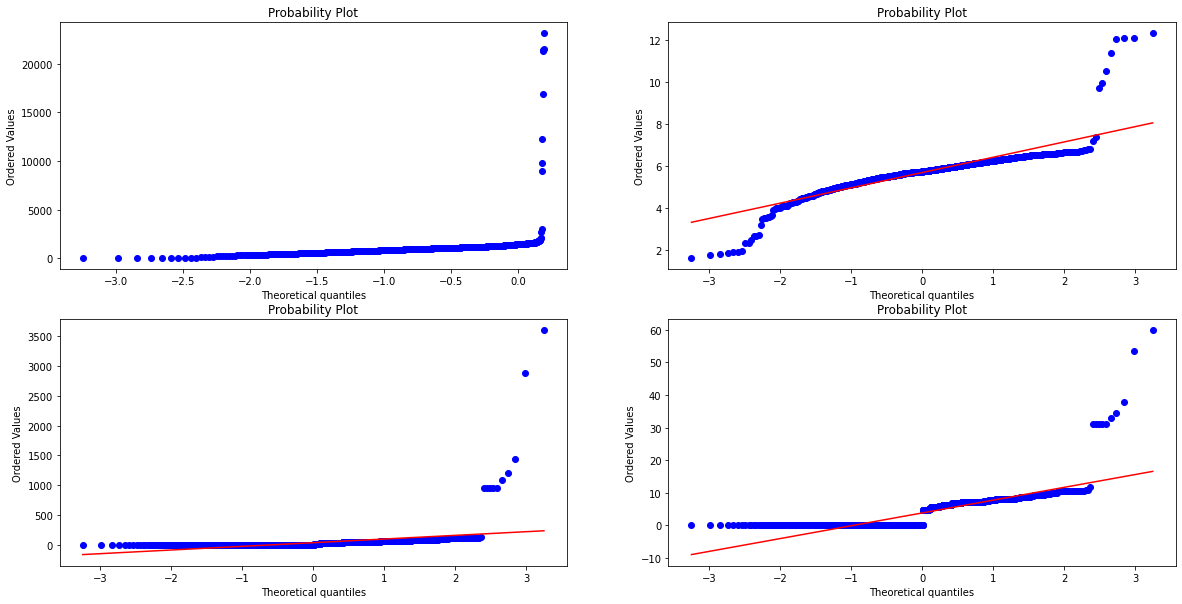

In [26]:
import scipy.stats as stats
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
stats.probplot(train_data['wip'], dist="norm", plot=plt)
plt.subplot(2,2,2)
stats.probplot(cleaned_train_data['wip'], dist="norm", plot=plt)
plt.subplot(2,2,3)
stats.probplot(train_data['incentive'], dist="norm", plot=plt)
plt.subplot(2,2,4)
stats.probplot(cleaned_train_data['incentive'], dist="norm", plot=plt)
plt.show()

In [27]:
X = cleaned_train_data.drop("actual_productivity", 1)
y = cleaned_train_data["actual_productivity"]

X_train,X_test,y_train,y_test = tts(X,y,test_size=0.15, random_state=42)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [28]:
def evaluate(model, X_test, y_test):
    print("Validation results")
    y_pred = model.predict(X_test)
    print('Model Performance')
    print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))  
    print('Mean Squared Error:', mean_squared_error(y_test, y_pred))   
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
    print('r2_score: ', r2_score(y_test,y_pred))
    VIL = 1/(1-(r2_score(y_test,y_pred)))
    print("Variance Inflation Factor (VIL): {:0.6f}% ".format(VIL))
    
        

    return evaluate

In [29]:
def evaluate_train(model, X_train, y_train):
  print("Train results")
  y_pred = model.predict(X_train)
  print('Mean Absolute Error:', mean_absolute_error(y_train, y_pred))  
  print('Mean Squared Error:', mean_squared_error(y_train, y_pred))   
  print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, y_pred)))
  print('r2_score: ', r2_score(y_train,y_pred))
  VIL = 1/(1-(r2_score(y_train,y_pred)))
  print("Variance Inflation Factor (VIL): {:0.6f}% ".format(VIL))

  return evaluate_train

#Decision Tree Regressor

##1st Attempt

In [30]:
dtree1 = DecisionTreeRegressor(random_state=42)
dtree1.fit(X_train, y_train)
evaluate_train(dtree1, X_train, y_train)
print("=============================================")
evaluate(dtree1, X_test, y_test)

Train results
Mean Absolute Error: 6.671957082379975e-05
Mean Squared Error: 1.692189739367859e-08
Root Mean Squared Error: 0.00013008419348129347
r2_score:  0.999999462299014
Variance Inflation Factor (VIL): 1859769.697497% 
Validation results
Model Performance
Mean Absolute Error: 0.05343932553874187
Mean Squared Error: 0.0106343196555804
Root Mean Squared Error: 0.10312283770135693
r2_score:  0.5640943267405021
Variance Inflation Factor (VIL): 2.294074% 


<function __main__.evaluate>

##2nd Attempt

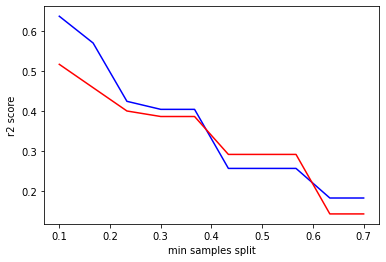

In [ ]:
min_sam = [float(x) for x in np.linspace(0.1, 0.7, num=10, endpoint=True)]
train_results = []
test_results = []
for min_samples_splits in min_sam:
   dt = DecisionTreeRegressor(min_samples_split = min_samples_splits, random_state=42)
   dt.fit(X_train, y_train)
   train_pred = dt.predict(X_train)
   r2_train = r2_score(y_train, train_pred)
   train_results.append(r2_train)

   test_pred = dt.predict(X_test)
   r2_test = r2_score(y_test, test_pred)
   test_results.append(r2_test)

line1, = plt.plot(min_sam, train_results, 'b', label = 'Train r2 score')
line2, = plt.plot(min_sam, test_results, 'r', label = 'Test r2 score')
plt.ylabel('r2 score')
plt.xlabel('min samples split')
plt.show()

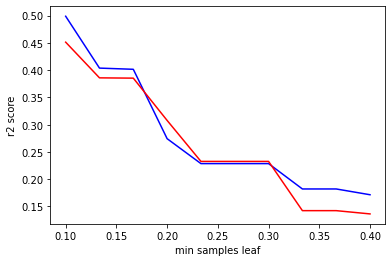

In [ ]:
min_samples_leafs = np.linspace(0.1, 0.4, num = 10, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
   dt = DecisionTreeRegressor(min_samples_leaf=min_samples_leaf, random_state=42)
   dt.fit(X_train, y_train)
   train_pred = dt.predict(X_train)
   r2_train = r2_score(y_train, train_pred)
   train_results.append(r2_train)

   test_pred = dt.predict(X_test)
   r2_test = r2_score(y_test, test_pred)
   test_results.append(r2_test)

line1, = plt.plot(min_samples_leafs, train_results, 'b', label = 'Train r2 score')
line2, = plt.plot(min_samples_leafs, test_results, 'r', label = 'Test r2 score')
plt.ylabel('r2 score')
plt.xlabel('min samples leaf')
plt.show()

In [ ]:
min_samples_splits = np.linspace(0.1, 0.7, num=10, endpoint=True)
min_samples_leaf = np.linspace(0.1, 0.4, num=5, endpoint=True)
dt = DecisionTreeRegressor(random_state=42)
random_dt_parameters = ({'criterion' : ['mse', 'friedman_mse', 'mae'],
                         'splitter' : ['best', 'random'],
                            'min_samples_split' : min_samples_splits,
                            'max_depth' : [8,10,12,15,20,24,32],
                            'min_samples_leaf' : [2,3,5],
                            'max_features' : ['auto', 'sqrt', 'log2', 5,6,7,10],
                            'min_samples_leaf' : min_samples_leaf})

random_search_dt = RandomizedSearchCV(dt, param_distributions= random_dt_parameters, n_iter=100, cv=8)
random_search_dt.fit(X_train,y_train)

random_search_dt.best_estimator_

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=0.1,
                      min_samples_split=0.23333333333333334,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [31]:
dtree2 = DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=0.1,
                      min_samples_split=0.23333333333333334,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')
dtree2.fit(X_train,y_train)
evaluate_train(dtree2, X_train, y_train)
print("=============================================")
evaluate(dtree2, X_test, y_test)

Train results
Mean Absolute Error: 0.10103009769497501
Mean Squared Error: 0.01821948204177854
Root Mean Squared Error: 0.13497956157055238
r2_score:  0.4210676717115137
Variance Inflation Factor (VIL): 1.727318% 
Validation results
Model Performance
Mean Absolute Error: 0.09050470040619266
Mean Squared Error: 0.014414704227731489
Root Mean Squared Error: 0.12006125198302527
r2_score:  0.4091346174714091
Variance Inflation Factor (VIL): 1.692433% 


<function __main__.evaluate>

#Random Forest Regressor

##1st Attempt

In [32]:
rf1 = RandomForestRegressor(random_state=42)
rf1.fit(X_train, y_train)
print("Validation results")
evaluate_train(rf1, X_train, y_train)
print("=============================================")
evaluate(rf1, X_test, y_test)

Validation results
Train results
Mean Absolute Error: 0.014456348401147717
Mean Squared Error: 0.0006580945139246995
Root Mean Squared Error: 0.02565335287880903
r2_score:  0.9790887475117753
Variance Inflation Factor (VIL): 47.821143% 
Validation results
Model Performance
Mean Absolute Error: 0.039607738453086926
Mean Squared Error: 0.005209840559297418
Root Mean Squared Error: 0.07217922526113325
r2_score:  0.7864462297422605
Variance Inflation Factor (VIL): 4.682661% 


<function __main__.evaluate>

##2nd Attempt

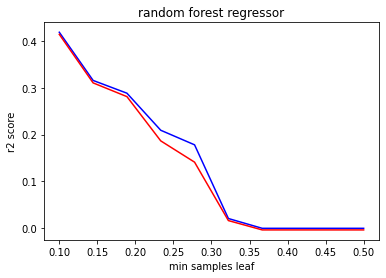

In [ ]:
min_samples_leafs = np.linspace(0.1, 0.5, num = 10, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
   rf = RandomForestRegressor(min_samples_leaf=min_samples_leaf, random_state=42)
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   r2_train = r2_score(y_train, train_pred)
   train_results.append(r2_train)

   test_pred = rf.predict(X_test)
   r2_test = r2_score(y_test, test_pred)
   test_results.append(r2_test)

line1, = plt.plot(min_samples_leafs, train_results, 'b', label = 'Train r2 score')
line2, = plt.plot(min_samples_leafs, test_results, 'r', label = 'Test r2 score')
plt.ylabel('r2 score')
plt.xlabel('min samples leaf')
plt.title('random forest regressor')
plt.show()

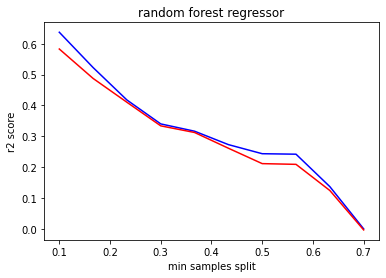

In [ ]:
min_sam = [float(x) for x in np.linspace(0.1, 0.7, num=10, endpoint=True)]
train_results = []
test_results = []
for min_samples_splits in min_sam:
   rf = RandomForestRegressor(min_samples_split = min_samples_splits, random_state=42)
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   r2_train = r2_score(y_train, train_pred)
   train_results.append(r2_train)

   test_pred = rf.predict(X_test)
   r2_test = r2_score(y_test, test_pred)
   test_results.append(r2_test)

line1, = plt.plot(min_sam, train_results, 'b', label = 'Train r2 score')
line2, = plt.plot(min_sam, test_results, 'r', label = 'Test r2 score')
plt.ylabel('r2 score')
plt.xlabel('min samples split')
plt.title('random forest regressor')
plt.show()

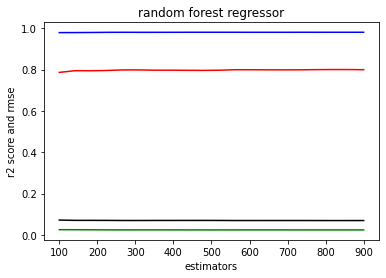

In [ ]:
est = [int(x) for x in np.linspace(100, 900, num=20, endpoint=True)]
train_results = []
test_results = []
train_rmse = []
test_rmse = []
for n_estimators in est:
  rf = RandomForestRegressor(n_estimators= n_estimators, random_state=42)
  rf.fit(X_train, y_train)
  train_pred = rf.predict(X_train)
  r2_train = r2_score(y_train, train_pred)
  mse_train = mean_squared_error(y_train, train_pred)
  rmse_train = np.sqrt(mean_squared_error(y_train,train_pred))
  train_results.append(r2_train)
  train_rmse.append(rmse_train)

  test_pred = rf.predict(X_test)
  mse_test =  mean_squared_error(y_test, test_pred)
  rmse_test = np.sqrt(mean_squared_error(y_test, test_pred))
  r2_test = r2_score(y_test, test_pred)
  test_results.append(r2_test)
  test_rmse.append(rmse_test)


line1, = plt.plot(est, train_results, 'b', label = 'Train r2 score')
line2, = plt.plot(est, test_results, 'r', label = 'Test r2 score')
line3, = plt.plot(est, train_rmse, 'g', label = 'train_rmse')
line4, = plt.plot(est, test_rmse, 'black', label = 'test_rmse')
plt.ylabel('r2 score and rmse')
plt.xlabel('estimators')
plt.title('random forest regressor')
plt.show()

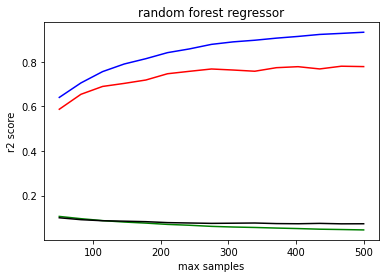

In [ ]:
max_sample = [int(x) for x in np.linspace(50, 500, num=15, endpoint=True)]
train_results = []
test_results = []
train_rmse = []
test_rmse = []
for max_samples in max_sample:
   rf = RandomForestRegressor(max_samples= max_samples, random_state=42)
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   r2_train = r2_score(y_train, train_pred)
   mse_train = mean_squared_error(y_train, train_pred)
   rmse_train = np.sqrt(mean_squared_error(y_train,train_pred))
   train_results.append(r2_train)
   train_rmse.append(rmse_train)

   test_pred = rf.predict(X_test)
   mse_test =  mean_squared_error(y_test, test_pred)
   rmse_test = np.sqrt(mean_squared_error(y_test, test_pred))
   r2_test = r2_score(y_test, test_pred)
   test_results.append(r2_test)
   test_rmse.append(rmse_test)

line1, = plt.plot(max_sample, train_results, 'b', label = 'Train r2 score')
line2, = plt.plot(max_sample, test_results, 'r', label = 'Test r2 score')
line3, = plt.plot(max_sample, train_rmse, 'g', label = 'train_rmse')
line4, = plt.plot(max_sample, test_rmse, 'black', label = 'test_rmse')
plt.ylabel('r2 score')
plt.xlabel('max samples')
plt.title('random forest regressor')
plt.show()

In [ ]:
max_samples = [int(x) for x in np.linspace(50, 500, num=10, endpoint=True)]
est = [int(x) for x in np.linspace(100, 900, num=11, endpoint=True)]
rf2 = RandomForestRegressor(random_state=42)
random_rf_parameters = ({'n_estimators' : est,
                            'criterion' : ['mse','mae'],
                            'min_samples_split' : [0.1,0.15,0.2,0.25,0.3],
                            'max_depth' : [8,10,12,15,20,24,32],
                            'min_samples_leaf' : [2,3,5],
                            'max_features' : ['auto', 'sqrt', 'log2', 5,6,7,10],
                            'max_samples' : max_samples,
                            'min_samples_leaf' : [0.1,0.15,0.2]})

random_search_rf = RandomizedSearchCV(rf2, param_distributions= random_rf_parameters, scoring = 'neg_mean_squared_error', n_iter=100, cv=10)
random_search_rf.fit(X_train,y_train)

random_search_rf.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=32, max_features=7, max_leaf_nodes=None,
                      max_samples=450, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=0.1,
                      min_samples_split=0.15, min_weight_fraction_leaf=0.0,
                      n_estimators=740, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [33]:
rf2 = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=32, max_features=7, max_leaf_nodes=None,
                      max_samples=450, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=0.1,
                      min_samples_split=0.15, min_weight_fraction_leaf=0.0,
                      n_estimators=740, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)
rf2.fit(X_train,y_train)
print("Validation data results")
evaluate_train(rf2, X_train, y_train)
print("=============================================")
evaluate(rf2, X_test, y_test)

Validation data results
Train results
Mean Absolute Error: 0.11185387206842577
Mean Squared Error: 0.021353304486073973
Root Mean Squared Error: 0.14612769924307292
r2_score:  0.32148903824880504
Variance Inflation Factor (VIL): 1.473816% 
Validation results
Model Performance
Mean Absolute Error: 0.09463235469592475
Mean Squared Error: 0.01629634860799713
Root Mean Squared Error: 0.12765715259239152
r2_score:  0.33200514544315085
Variance Inflation Factor (VIL): 1.497018% 


<function __main__.evaluate>

#Gradient Boosting Regressor

##1st Attempt

In [34]:
gbdt1 = GradientBoostingRegressor(random_state=42)
gbdt1.fit(X_train, y_train)
evaluate_train(gbdt1, X_train, y_train)
print("=====================================================")
evaluate(gbdt1, X_test, y_test)

Train results
Mean Absolute Error: 0.03868611071323854
Mean Squared Error: 0.0032523834358759427
Root Mean Squared Error: 0.05702967153926053
r2_score:  0.8966540371070416
Variance Inflation Factor (VIL): 9.676237% 
Validation results
Model Performance
Mean Absolute Error: 0.0461944309755905
Mean Squared Error: 0.004935829715480634
Root Mean Squared Error: 0.07025546039619009
r2_score:  0.7976780607594596
Variance Inflation Factor (VIL): 4.942618% 


<function __main__.evaluate>

##2nd Attempt

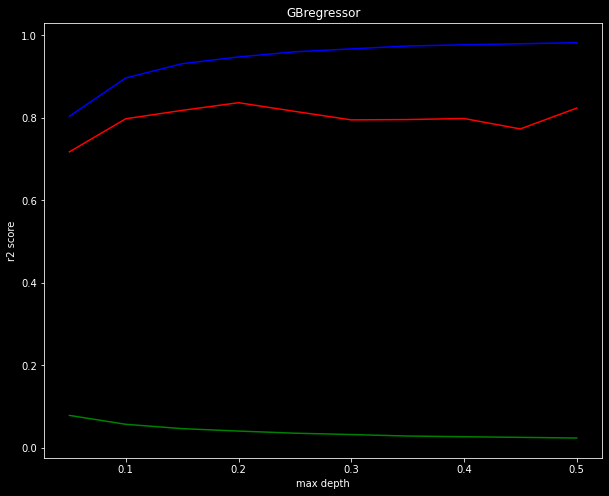

In [ ]:
learning = [float(x) for x in np.linspace(0.05,0.5,num=10, endpoint=True)]
train_results = []
test_results = []
train_rmse = []
test_rmse = []
for learning_rate in learning:
   gb = GradientBoostingRegressor(learning_rate = learning_rate, random_state=42)
   gb.fit(X_train, y_train)
   train_pred = gb.predict(X_train)
   r2_train = r2_score(y_train, train_pred)
   mse_train = mean_squared_error(y_train, train_pred)
   rmse_train = np.sqrt(mean_squared_error(y_train,train_pred))
   train_results.append(r2_train)
   train_rmse.append(rmse_train)

   test_pred = gb.predict(X_test)
   mse_test =  mean_squared_error(y_test, test_pred)
   rmse_test = np.sqrt(mean_squared_error(y_test, test_pred))
   r2_test = r2_score(y_test, test_pred)
   test_results.append(r2_test)
   test_rmse.append(rmse_test)

plt.figure(figsize=(10,8))
line1, = plt.plot(learning, train_results, 'b', label = 'Train r2 score')
line2, = plt.plot(learning, test_results, 'r', label = 'Test r2 score')
line3, = plt.plot(learning, train_rmse, 'g', label = 'train_rmse')
line4, = plt.plot(learning, test_rmse, 'black', label = 'test_rmse')
plt.ylabel('r2 score')
plt.xlabel('max depth')
plt.title('GBregressor')
plt.show()


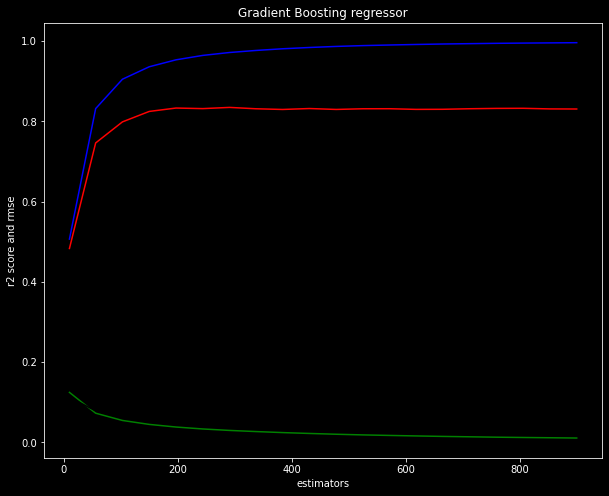

In [ ]:
est = [int(x) for x in np.linspace(10, 900, num=20, endpoint=True)]
train_results = []
test_results = []
train_rmse = []
test_rmse = []
for n_estimators in est:
  gb = GradientBoostingRegressor(n_estimators= n_estimators, subsample = 0.8, random_state=42)
  gb.fit(X_train, y_train)
  train_pred = gb.predict(X_train)
  r2_train = r2_score(y_train, train_pred)
  mse_train = mean_squared_error(y_train, train_pred)
  rmse_train = np.sqrt(mean_squared_error(y_train,train_pred))
  train_results.append(r2_train)
  train_rmse.append(rmse_train)

  test_pred = gb.predict(X_test)
  mse_test =  mean_squared_error(y_test, test_pred)
  rmse_test = np.sqrt(mean_squared_error(y_test, test_pred))
  r2_test = r2_score(y_test, test_pred)
  test_results.append(r2_test)
  test_rmse.append(rmse_test)

plt.figure(figsize=(10,8))
line1, = plt.plot(est, train_results, 'b', label = 'Train r2 score')
line2, = plt.plot(est, test_results, 'r', label = 'Test r2 score')
line3, = plt.plot(est, train_rmse, 'g', label = 'train_rmse')
line4, = plt.plot(est, test_rmse, 'black', label = 'test_rmse')
plt.ylabel('r2 score and rmse')
plt.xlabel('estimators')
plt.title('Gradient Boosting regressor')
plt.show()

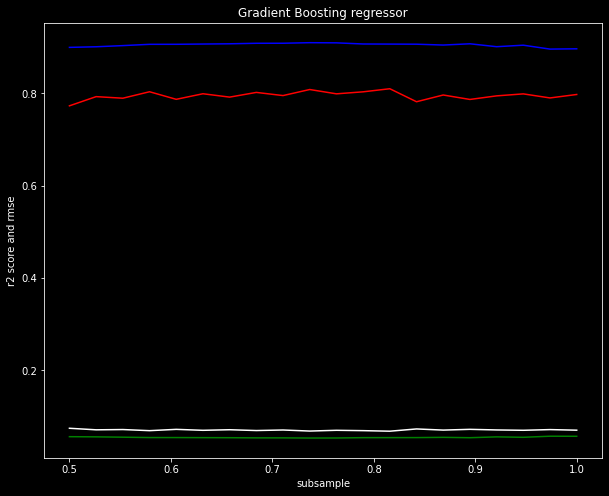

In [ ]:
sample = [float(x) for x in np.linspace(0.5, 1.0, num=20, endpoint=True)]
train_results = []
test_results = []
train_rmse = []
test_rmse = []
for samples in sample:
  gb = GradientBoostingRegressor(subsample = samples, random_state=42)
  gb.fit(X_train, y_train)
  train_pred = gb.predict(X_train)
  r2_train = r2_score(y_train, train_pred)
  mse_train = mean_squared_error(y_train, train_pred)
  rmse_train = np.sqrt(mean_squared_error(y_train,train_pred))
  train_results.append(r2_train)
  train_rmse.append(rmse_train)

  test_pred = gb.predict(X_test)
  mse_test =  mean_squared_error(y_test, test_pred)
  rmse_test = np.sqrt(mean_squared_error(y_test, test_pred))
  r2_test = r2_score(y_test, test_pred)
  test_results.append(r2_test)
  test_rmse.append(rmse_test)

plt.figure(figsize=(10,8))
line1, = plt.plot(sample, train_results, 'b', label = 'Train r2 score')
line2, = plt.plot(sample, test_results, 'r', label = 'Test r2 score')
line3, = plt.plot(sample, train_rmse, 'g', label = 'train_rmse')
line4, = plt.plot(sample, test_rmse, 'white', label = 'test_rmse')
plt.ylabel('r2 score and rmse')
plt.xlabel('subsample')
plt.title('Gradient Boosting regressor')
plt.show()

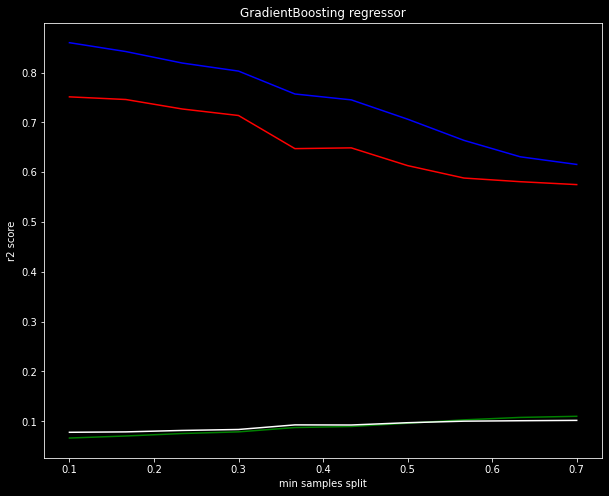

In [ ]:
min_sam = [float(x) for x in np.linspace(0.1, 0.7, num=10, endpoint=True)]
train_results = []
test_results = []
train_rmse = []
test_rmse = []
for min_samples_splits in min_sam:
   gb = GradientBoostingRegressor(min_samples_split = min_samples_splits, random_state=42)
   gb.fit(X_train, y_train)
   train_pred = gb.predict(X_train)
   r2_train = r2_score(y_train, train_pred)
   mse_train = mean_squared_error(y_train, train_pred)
   rmse_train = np.sqrt(mean_squared_error(y_train,train_pred))
   train_results.append(r2_train)
   train_rmse.append(rmse_train)

   test_pred = gb.predict(X_test)
   mse_test =  mean_squared_error(y_test, test_pred)
   rmse_test = np.sqrt(mean_squared_error(y_test, test_pred))
   r2_test = r2_score(y_test, test_pred)
   test_results.append(r2_test)
   test_rmse.append(rmse_test)
plt.figure(figsize=(10,8))
line1, = plt.plot(min_sam, train_results, 'b', label = 'Train r2 score')
line2, = plt.plot(min_sam, test_results, 'r', label = 'Test r2 score')
line3, = plt.plot(min_sam, train_rmse, 'g', label = 'train_rmse')
line4, = plt.plot(min_sam, test_rmse, 'white', label = 'test_rmse')
plt.ylabel('r2 score')
plt.xlabel('min samples split')
plt.title('GradientBoosting regressor')
plt.show()

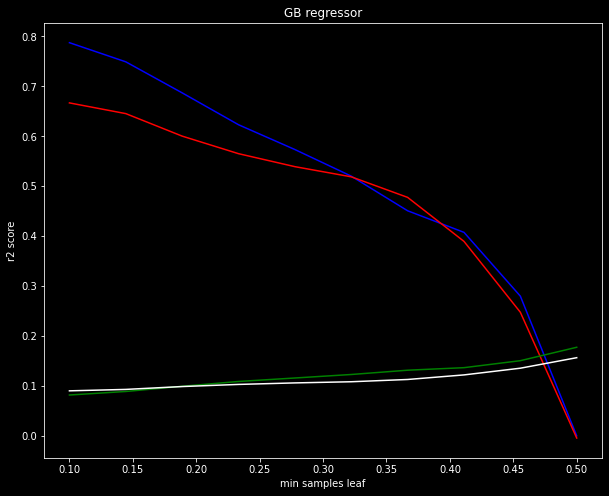

In [ ]:
min_samples_leafs = np.linspace(0.1, 0.5, num = 10, endpoint=True)
train_results = []
test_results = []
train_rmse = []
test_rmse = []
for min_samples_leaf in min_samples_leafs:
   gb = GradientBoostingRegressor(min_samples_leaf= min_samples_leaf, random_state=42)
   gb.fit(X_train, y_train)
   train_pred = gb.predict(X_train)
   r2_train = r2_score(y_train, train_pred)
   mse_train = mean_squared_error(y_train, train_pred)
   rmse_train = np.sqrt(mean_squared_error(y_train,train_pred))
   train_results.append(r2_train)
   train_rmse.append(rmse_train)

   test_pred = gb.predict(X_test)
   mse_test =  mean_squared_error(y_test, test_pred)
   rmse_test = np.sqrt(mean_squared_error(y_test, test_pred))
   r2_test = r2_score(y_test, test_pred)
   test_results.append(r2_test)
   test_rmse.append(rmse_test)
plt.figure(figsize=(10,8))
line1, = plt.plot(min_samples_leafs, train_results, 'b', label = 'Train r2 score')
line2, = plt.plot(min_samples_leafs, test_results, 'r', label = 'Test r2 score')
line3, = plt.plot(min_samples_leafs, train_rmse, 'g', label = 'train_rmse')
line4, = plt.plot(min_samples_leafs, test_rmse, 'white', label = 'test_rmse')
plt.ylabel('r2 score')
plt.xlabel('min samples leaf')
plt.title('GB regressor')
plt.show()

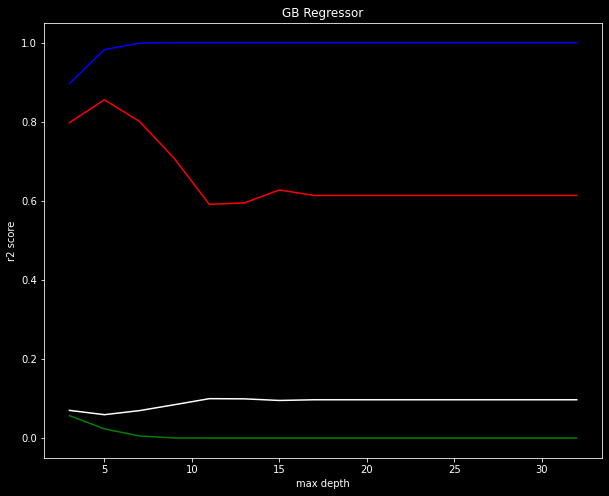

In [ ]:
depth = [int(x) for x in np.linspace(3,32,num=15, endpoint=True)]
train_results = []
test_results = []
train_rmse = []
test_rmse = []
for max_depth in depth:
   gb = GradientBoostingRegressor(max_depth= max_depth, random_state=42)
   gb.fit(X_train, y_train)
   train_pred = gb.predict(X_train)
   r2_train = r2_score(y_train, train_pred)
   mse_train = mean_squared_error(y_train, train_pred)
   rmse_train = np.sqrt(mean_squared_error(y_train,train_pred))
   train_results.append(r2_train)
   train_rmse.append(rmse_train)

   test_pred = gb.predict(X_test)
   mse_test =  mean_squared_error(y_test, test_pred)
   rmse_test = np.sqrt(mean_squared_error(y_test, test_pred))
   r2_test = r2_score(y_test, test_pred)
   test_results.append(r2_test)
   test_rmse.append(rmse_test)

plt.figure(figsize=(10,8))
line1, = plt.plot(depth, train_results, 'b', label = 'Train r2 score')
line2, = plt.plot(depth, test_results, 'r', label = 'Test r2 score')
line3, = plt.plot(depth, train_rmse, 'g', label = 'train_rmse')
line4, = plt.plot(depth, test_rmse, 'white', label = 'test_rmse')
plt.ylabel('r2 score')
plt.xlabel('max depth')
plt.title('GB Regressor')
plt.show()


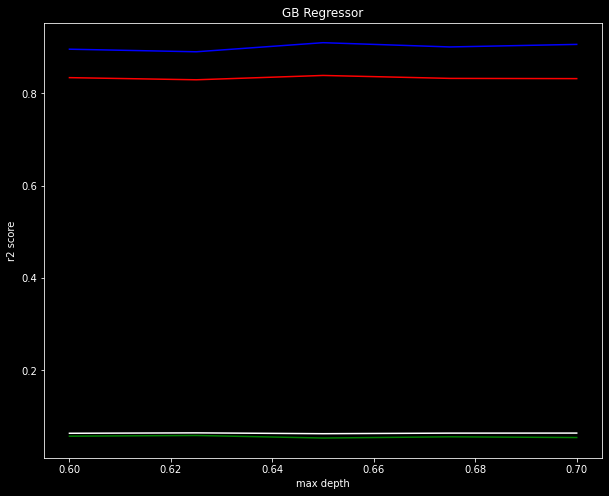

In [ ]:
alpha = [float(x) for x in np.linspace(0.6, 0.7,num=5)]
train_results = []
test_results = []
train_rmse = []
test_rmse = []
for alph in alpha:
   gb = GradientBoostingRegressor(alpha = alph, loss = 'huber', learning_rate = 0.2, random_state=42)
   gb.fit(X_train, y_train)
   train_pred = gb.predict(X_train)
   r2_train = r2_score(y_train, train_pred)
   mse_train = mean_squared_error(y_train, train_pred)
   rmse_train = np.sqrt(mean_squared_error(y_train,train_pred))
   train_results.append(r2_train)
   train_rmse.append(rmse_train)

   test_pred = gb.predict(X_test)
   mse_test =  mean_squared_error(y_test, test_pred)
   rmse_test = np.sqrt(mean_squared_error(y_test, test_pred))
   r2_test = r2_score(y_test, test_pred)
   test_results.append(r2_test)
   test_rmse.append(rmse_test)

plt.figure(figsize=(10,8))
line1, = plt.plot(alpha, train_results, 'b', label = 'Train r2 score')
line2, = plt.plot(alpha, test_results, 'r', label = 'Test r2 score')
line3, = plt.plot(alpha, train_rmse, 'g', label = 'train_rmse')
line4, = plt.plot(alpha, test_rmse, 'white', label = 'test_rmse')
plt.ylabel('r2 score')
plt.xlabel('max depth')
plt.title('GB Regressor')
plt.show()


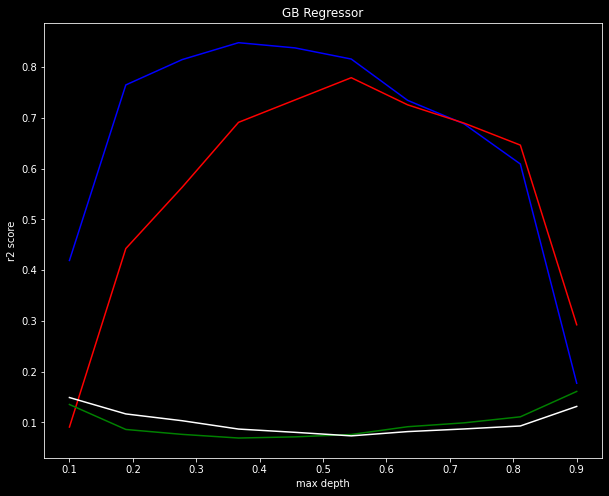

In [ ]:
alpha = [float(x) for x in np.linspace(0.1,0.9,num=10)]
train_results = []
test_results = []
train_rmse = []
test_rmse = []
for alph in alpha:
   gb = GradientBoostingRegressor(alpha = alph, loss = 'quantile', learning_rate = 0.2, max_depth=3, random_state=42)
   gb.fit(X_train, y_train)
   train_pred = gb.predict(X_train)
   r2_train = r2_score(y_train, train_pred)
   mse_train = mean_squared_error(y_train, train_pred)
   rmse_train = np.sqrt(mean_squared_error(y_train,train_pred))
   train_results.append(r2_train)
   train_rmse.append(rmse_train)

   test_pred = gb.predict(X_test)
   mse_test =  mean_squared_error(y_test, test_pred)
   rmse_test = np.sqrt(mean_squared_error(y_test, test_pred))
   r2_test = r2_score(y_test, test_pred)
   test_results.append(r2_test)
   test_rmse.append(rmse_test)

plt.figure(figsize=(10,8))
line1, = plt.plot(alpha, train_results, 'b', label = 'Train r2 score')
line2, = plt.plot(alpha, test_results, 'r', label = 'Test r2 score')
line3, = plt.plot(alpha, train_rmse, 'g', label = 'train_rmse')
line4, = plt.plot(alpha, test_rmse, 'white', label = 'test_rmse')
plt.ylabel('r2 score')
plt.xlabel('max depth')
plt.title('GB Regressor')
plt.show()


In [ ]:
gbdt2 = GradientBoostingRegressor(random_state=42)
learning = [float(x) for x in np.linspace(0.05,0.5,num=10, endpoint=True)]
est = [int(x) for x in np.linspace(100, 900, num=20, endpoint=True)]
sample = [float(x) for x in np.linspace(0.5, 1.0, num=20, endpoint=True)]
min_samples_leafs = np.linspace(0.1, 0.2, num = 5, endpoint=True)
alpha = [float(x) for x in np.linspace(0.6, 0.7,num=5)]
min_samples_splits = [float(x) for x in np.linspace(0.1, 0.2, num=5, endpoint=True)]
random_params = ({'learning_rate' : learning,
                  'loss' : ['ls', 'lad', 'huber', 'quantile'],
                  'n_estimators' : est,
                  'subsample' : sample,
                  'criterion' : ['friedman_mse', 'mse', 'mae'],
                  'min_samples_split' : min_samples_splits,
                  'min_samples_leaf' : min_samples_leafs,
                  'max_depth' : [3,4,5,8],
                  'alpha' : alpha})

random_search_gb = RandomizedSearchCV(gbdt2, param_distributions= random_params, n_iter = 60, scoring= 'neg_mean_squared_error', cv = 5)
random_search_gb.fit(X_train, y_train)

random_search_gb.best_estimator_

GradientBoostingRegressor(alpha=0.6499999999999999, ccp_alpha=0.0,
                          criterion='mse', init=None,
                          learning_rate=0.15000000000000002, loss='ls',
                          max_depth=8, max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=0.125, min_samples_split=0.2,
                          min_weight_fraction_leaf=0.0, n_estimators=605,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=0.9210526315789473,
                          tol=0.0001, validation_fraction=0.1, verbose=0,
                          warm_start=False)

In [35]:
gbdt2 = GradientBoostingRegressor(alpha=0.6499999999999999, ccp_alpha=0.0,
                          criterion='mse', init=None,
                          learning_rate=0.15000000000000002, loss='ls',
                          max_depth=8, max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=0.125, min_samples_split=0.2,
                          min_weight_fraction_leaf=0.0, n_estimators=605,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=0.9210526315789473,
                          tol=0.0001, validation_fraction=0.1, verbose=0,
                          warm_start=False)
gbdt2.fit(X_train, y_train)
evaluate_train(gbdt2, X_train, y_train)
print("==========================================================")
evaluate(gbdt2, X_test, y_test)

Train results
Mean Absolute Error: 0.03578009431611253
Mean Squared Error: 0.0026671371496437618
Root Mean Squared Error: 0.051644333180357375
r2_score:  0.9152505040282007
Variance Inflation Factor (VIL): 11.799480% 
Validation results
Model Performance
Mean Absolute Error: 0.0554319319259603
Mean Squared Error: 0.006345107418952912
Root Mean Squared Error: 0.07965618255322629
r2_score:  0.7399111169362766
Variance Inflation Factor (VIL): 3.844839% 


<function __main__.evaluate>

#HistGradientBoostingRegressor (histogram based Gradient Boosting Regressor)

##1st Attempt

In [36]:
histgb1 = HistGradientBoostingRegressor(random_state=42)
histgb1.fit(X_train, y_train)
print("Training data results")
evaluate_train(histgb1, X_train, y_train)
print("=========================================================")
evaluate(histgb1, X_test, y_test)

Training data results
Train results
Mean Absolute Error: 0.017320981776232015
Mean Squared Error: 0.0008144426218842416
Root Mean Squared Error: 0.02853844112568592
r2_score:  0.9741207152726064
Variance Inflation Factor (VIL): 38.640944% 
Validation results
Model Performance
Mean Absolute Error: 0.03975976051484696
Mean Squared Error: 0.00441181915071839
Root Mean Squared Error: 0.06642152626007919
r2_score:  0.8191574957798196
Variance Inflation Factor (VIL): 5.529673% 


<function __main__.evaluate>

##2nd Attempt

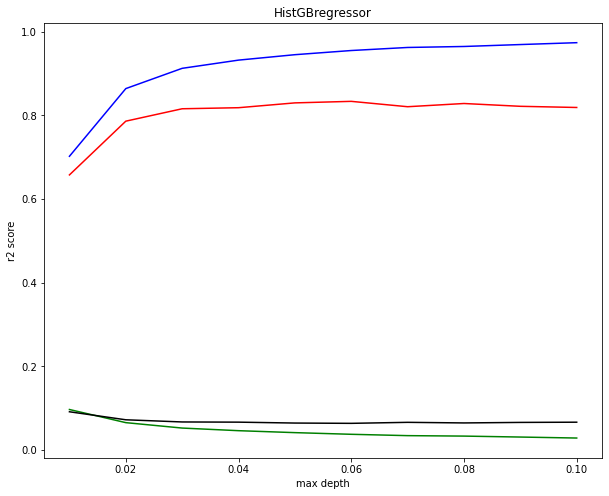

In [ ]:
learning = [float(x) for x in np.linspace(0.01,0.1,num=10, endpoint=True)]
train_results = []
test_results = []
train_rmse = []
test_rmse = []
for learning_rate in learning:
   histgb = HistGradientBoostingRegressor(learning_rate = learning_rate, random_state=42)
   histgb.fit(X_train, y_train)
   train_pred = histgb.predict(X_train)
   r2_train = r2_score(y_train, train_pred)
   mse_train = mean_squared_error(y_train, train_pred)
   rmse_train = np.sqrt(mean_squared_error(y_train,train_pred))
   train_results.append(r2_train)
   train_rmse.append(rmse_train)

   test_pred = histgb.predict(X_test)
   mse_test =  mean_squared_error(y_test, test_pred)
   rmse_test = np.sqrt(mean_squared_error(y_test, test_pred))
   r2_test = r2_score(y_test, test_pred)
   test_results.append(r2_test)
   test_rmse.append(rmse_test)

plt.figure(figsize=(10,8))
line1, = plt.plot(learning, train_results, 'b', label = 'Train r2 score')
line2, = plt.plot(learning, test_results, 'r', label = 'Test r2 score')
line3, = plt.plot(learning, train_rmse, 'g', label = 'train_rmse')
line4, = plt.plot(learning, test_rmse, 'black', label = 'test_rmse')
plt.ylabel('r2 score')
plt.xlabel('max depth')
plt.title('HistGBregressor')
plt.show()


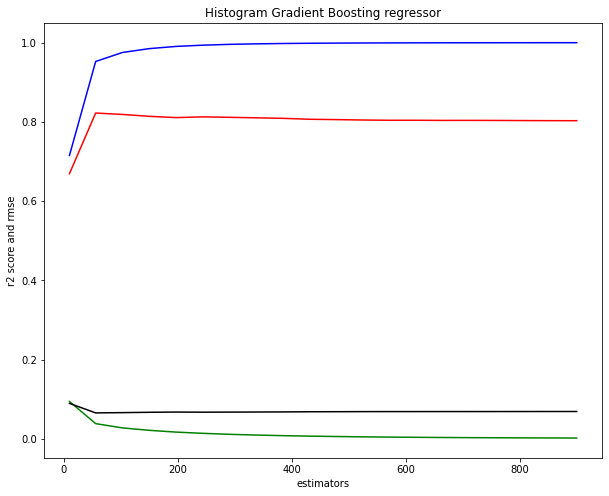

In [ ]:
iter = [int(x) for x in np.linspace(10, 900, num=20, endpoint=True)]
train_results = []
test_results = []
train_rmse = []
test_rmse = []
for n_estimators in iter:
  histgb = HistGradientBoostingRegressor(max_iter= n_estimators, random_state=42)
  histgb.fit(X_train, y_train)
  train_pred = histgb.predict(X_train)
  r2_train = r2_score(y_train, train_pred)
  mse_train = mean_squared_error(y_train, train_pred)
  rmse_train = np.sqrt(mean_squared_error(y_train,train_pred))
  train_results.append(r2_train)
  train_rmse.append(rmse_train)

  test_pred = histgb.predict(X_test)
  mse_test =  mean_squared_error(y_test, test_pred)
  rmse_test = np.sqrt(mean_squared_error(y_test, test_pred))
  r2_test = r2_score(y_test, test_pred)
  test_results.append(r2_test)
  test_rmse.append(rmse_test)

plt.figure(figsize=(10,8))
line1, = plt.plot(iter, train_results, 'b', label = 'Train r2 score')
line2, = plt.plot(iter, test_results, 'r', label = 'Test r2 score')
line3, = plt.plot(iter, train_rmse, 'g', label = 'train_rmse')
line4, = plt.plot(iter, test_rmse, 'black', label = 'test_rmse')
plt.ylabel('r2 score and rmse')
plt.xlabel('estimators')
plt.title('Histogram Gradient Boosting regressor')
plt.show()

In [ ]:
[int(x) for x in np.linspace(50,255, num=10, endpoint =True)]

[50, 72, 95, 118, 141, 163, 186, 209, 232, 255]

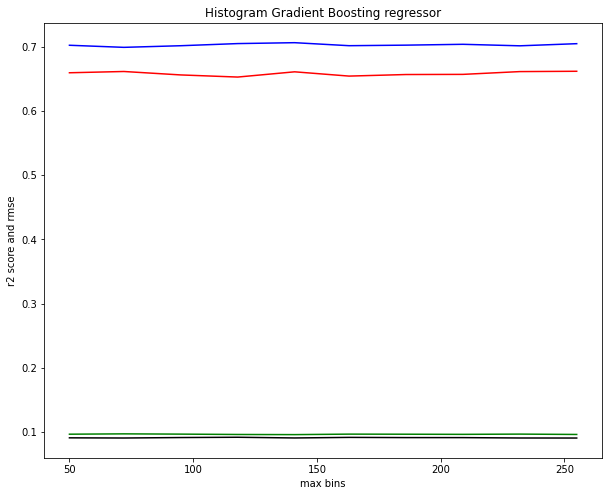

In [ ]:
bins = [int(x) for x in np.linspace(50,255, num=10, endpoint =True)]
train_results = []
test_results = []
train_rmse = []
test_rmse = []
for bin in bins:
  histgb = HistGradientBoostingRegressor(max_bins = bin, max_iter = 50, learning_rate = 0.02, random_state=42)
  histgb.fit(X_train, y_train)
  train_pred = histgb.predict(X_train)
  r2_train = r2_score(y_train, train_pred)
  mse_train = mean_squared_error(y_train, train_pred)
  rmse_train = np.sqrt(mean_squared_error(y_train,train_pred))
  train_results.append(r2_train)
  train_rmse.append(rmse_train)

  test_pred = histgb.predict(X_test)
  mse_test =  mean_squared_error(y_test, test_pred)
  rmse_test = np.sqrt(mean_squared_error(y_test, test_pred))
  r2_test = r2_score(y_test, test_pred)
  test_results.append(r2_test)
  test_rmse.append(rmse_test)

plt.figure(figsize=(10,8))
line1, = plt.plot(bins, train_results, 'b', label = 'Train r2 score')
line2, = plt.plot(bins, test_results, 'r', label = 'Test r2 score')
line3, = plt.plot(bins, train_rmse, 'g', label = 'train_rmse')
line4, = plt.plot(bins, test_rmse, 'black', label = 'test_rmse')
plt.ylabel('r2 score and rmse')
plt.xlabel('max bins')
plt.title('Histogram Gradient Boosting regressor')
plt.show()

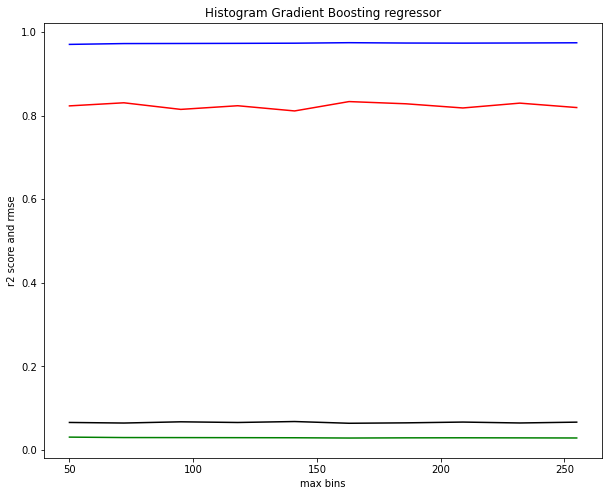

In [ ]:
bins = [int(x) for x in np.linspace(50,255, num=10, endpoint =True)]
train_results = []
test_results = []
train_rmse = []
test_rmse = []
for bin in bins:
  histgb = HistGradientBoostingRegressor(max_bins = bin,  random_state=42)
  histgb.fit(X_train, y_train)
  train_pred = histgb.predict(X_train)
  r2_train = r2_score(y_train, train_pred)
  mse_train = mean_squared_error(y_train, train_pred)
  rmse_train = np.sqrt(mean_squared_error(y_train,train_pred))
  train_results.append(r2_train)
  train_rmse.append(rmse_train)

  test_pred = histgb.predict(X_test)
  mse_test =  mean_squared_error(y_test, test_pred)
  rmse_test = np.sqrt(mean_squared_error(y_test, test_pred))
  r2_test = r2_score(y_test, test_pred)
  test_results.append(r2_test)
  test_rmse.append(rmse_test)

plt.figure(figsize=(10,8))
line1, = plt.plot(bins, train_results, 'b', label = 'Train r2 score')
line2, = plt.plot(bins, test_results, 'r', label = 'Test r2 score')
line3, = plt.plot(bins, train_rmse, 'g', label = 'train_rmse')
line4, = plt.plot(bins, test_rmse, 'black', label = 'test_rmse')
plt.ylabel('r2 score and rmse')
plt.xlabel('max bins')
plt.title('Histogram Gradient Boosting regressor')
plt.show()

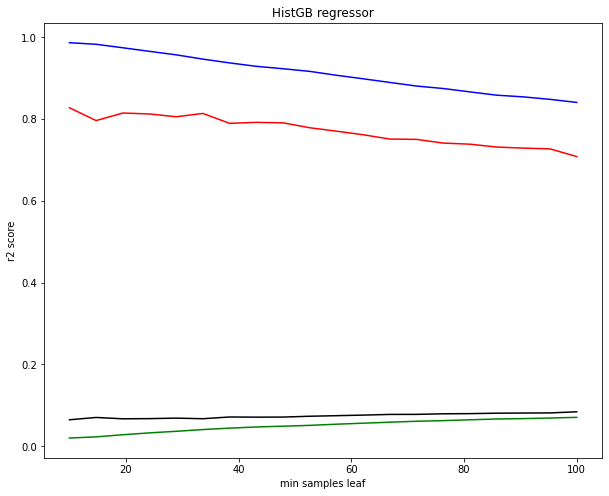

In [ ]:
min_samples_leafs = [float(x) for x in np.linspace(10, 100, num = 20, endpoint=True)]
train_results = []
test_results = []
train_rmse = []
test_rmse = []
for min_samples_leaf in min_samples_leafs:
   histgb = HistGradientBoostingRegressor(min_samples_leaf= min_samples_leaf, random_state=42)
   histgb.fit(X_train, y_train)
   train_pred = histgb.predict(X_train)
   r2_train = r2_score(y_train, train_pred)
   mse_train = mean_squared_error(y_train, train_pred)
   rmse_train = np.sqrt(mean_squared_error(y_train,train_pred))
   train_results.append(r2_train)
   train_rmse.append(rmse_train)

   test_pred = histgb.predict(X_test)
   mse_test =  mean_squared_error(y_test, test_pred)
   rmse_test = np.sqrt(mean_squared_error(y_test, test_pred))
   r2_test = r2_score(y_test, test_pred)
   test_results.append(r2_test)
   test_rmse.append(rmse_test)
plt.figure(figsize=(10,8))
line1, = plt.plot(min_samples_leafs, train_results, 'b', label = 'Train r2 score')
line2, = plt.plot(min_samples_leafs, test_results, 'r', label = 'Test r2 score')
line3, = plt.plot(min_samples_leafs, train_rmse, 'g', label = 'train_rmse')
line4, = plt.plot(min_samples_leafs, test_rmse, 'black', label = 'test_rmse')
plt.ylabel('r2 score')
plt.xlabel('min samples leaf')
plt.title('HistGB regressor')
plt.show()

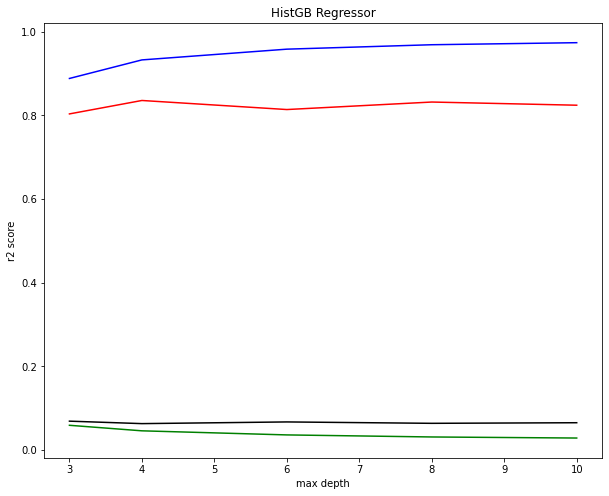

In [ ]:
depth = [int(x) for x in np.linspace(3,10,num=5, endpoint=True)]
train_results = []
test_results = []
train_rmse = []
test_rmse = []
for max_depth in depth:
   histgb = HistGradientBoostingRegressor(max_depth= max_depth, random_state=42)
   histgb.fit(X_train, y_train)
   train_pred = histgb.predict(X_train)
   r2_train = r2_score(y_train, train_pred)
   mse_train = mean_squared_error(y_train, train_pred)
   rmse_train = np.sqrt(mean_squared_error(y_train,train_pred))
   train_results.append(r2_train)
   train_rmse.append(rmse_train)

   test_pred = histgb.predict(X_test)
   mse_test =  mean_squared_error(y_test, test_pred)
   rmse_test = np.sqrt(mean_squared_error(y_test, test_pred))
   r2_test = r2_score(y_test, test_pred)
   test_results.append(r2_test)
   test_rmse.append(rmse_test)

plt.figure(figsize=(10,8))
line1, = plt.plot(depth, train_results, 'b', label = 'Train r2 score')
line2, = plt.plot(depth, test_results, 'r', label = 'Test r2 score')
line3, = plt.plot(depth, train_rmse, 'g', label = 'train_rmse')
line4, = plt.plot(depth, test_rmse, 'black', label = 'test_rmse')
plt.ylabel('r2 score')
plt.xlabel('max depth')
plt.title('HistGB Regressor')
plt.show()


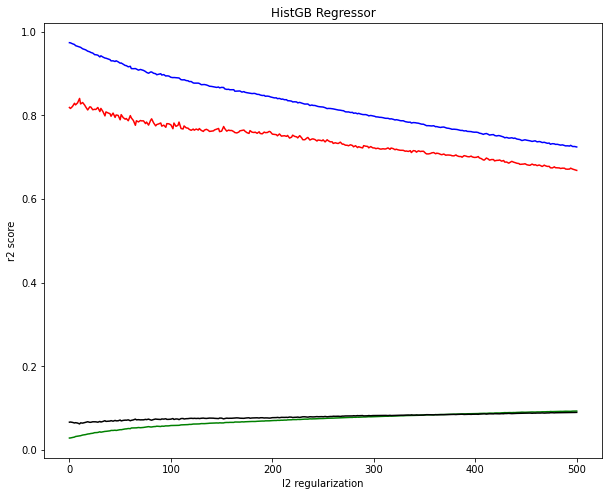

In [ ]:
ridge = [int(x) for x in np.linspace(0,500,num=300, endpoint=True)]
train_results = []
test_results = []
train_rmse = []
test_rmse = []
for l2 in ridge:
   histgb = HistGradientBoostingRegressor(l2_regularization = l2, random_state=42)
   histgb.fit(X_train, y_train)
   train_pred = histgb.predict(X_train)
   r2_train = r2_score(y_train, train_pred)
   mse_train = mean_squared_error(y_train, train_pred)
   rmse_train = np.sqrt(mean_squared_error(y_train,train_pred))
   train_results.append(r2_train)
   train_rmse.append(rmse_train)

   test_pred = histgb.predict(X_test)
   mse_test =  mean_squared_error(y_test, test_pred)
   rmse_test = np.sqrt(mean_squared_error(y_test, test_pred))
   r2_test = r2_score(y_test, test_pred)
   test_results.append(r2_test)
   test_rmse.append(rmse_test)

plt.figure(figsize=(10,8))
line1, = plt.plot(ridge, train_results, 'b', label = 'Train r2 score')
line2, = plt.plot(ridge, test_results, 'r', label = 'Test r2 score')
line3, = plt.plot(ridge, train_rmse, 'g', label = 'train_rmse')
line4, = plt.plot(ridge, test_rmse, 'black', label = 'test_rmse')
plt.ylabel('r2 score')
plt.xlabel('l2 regularization')
plt.title('HistGB Regressor')
plt.show()


In [ ]:
histgbm2 = HistGradientBoostingRegressor(random_state=42)

max_bins = [int(x) for x in np.linspace(50,255, num=10, endpoint =True)]
iter = [int(x) for x in np.linspace(100, 500, num=20, endpoint=True)]
learning = [float(x) for x in np.linspace(0.01,0.1,num=10, endpoint=True)]
min_samples_leafs = [float(x) for x in np.linspace(10, 50, num = 20, endpoint=True)]
depth = [int(x) for x in np.linspace(3,10,num=5, endpoint=True)]
ridge = [int(x) for x in np.linspace(0,500,num=300, endpoint=True)]

random_histgbm_params = ({'max_bins' : max_bins,
                'max_iter' : iter,
                'learning_rate' : learning,
                'min_samples_leaf' : min_samples_leafs,
                'max_depth' : depth,
                'l2_regularization' : ridge,
                'loss' : ['least_squares', 'least_absolute_deviation', 'poisson']})
random_search_histgbm = RandomizedSearchCV(estimator = histgbm2, param_distributions = random_histgbm_params, scoring= 'neg_mean_squared_error', cv = 10, n_jobs = -1, n_iter = 100)
random_search_histgbm.fit(X_train, y_train)

random_search_histgbm.best_estimator_

HistGradientBoostingRegressor(l2_regularization=5, learning_rate=0.1,
                              loss='least_squares', max_bins=141, max_depth=8,
                              max_iter=436, max_leaf_nodes=31,
                              min_samples_leaf=18.421052631578945,
                              n_iter_no_change=None, random_state=42,
                              scoring=None, tol=1e-07, validation_fraction=0.1,
                              verbose=0, warm_start=False)

I again tuned n_estimators and l2_regularization and the overfitting got reduced by 1% from difference of 12 to 11 but it is still to much

In [37]:
histgbm2 = HistGradientBoostingRegressor(l2_regularization=320, learning_rate=0.1,
                              loss='least_squares', max_bins=141, max_depth=8,
                              max_iter=336, max_leaf_nodes=31,
                              min_samples_leaf=18.421052631578945,
                              n_iter_no_change=None, random_state=42,
                              scoring='neg_mean_squared_error', tol=1e-07, validation_fraction=0.1,
                              verbose=0, warm_start=False)
histgbm2.fit(X_train,y_train)
print("Training data results")
evaluate_train(histgbm2, X_train, y_train)
print("Validation data results")
evaluate(histgbm2, X_test, y_test)

Training data results
Train results
Mean Absolute Error: 0.03091442604382353
Mean Squared Error: 0.0025262855426562937
Root Mean Squared Error: 0.050262168105408005
r2_score:  0.9197261279010114
Variance Inflation Factor (VIL): 12.457353% 
Validation data results
Validation results
Model Performance
Mean Absolute Error: 0.04353389043210393
Mean Squared Error: 0.004873152406133841
Root Mean Squared Error: 0.06980796807051357
r2_score:  0.8002472326118941
Variance Inflation Factor (VIL): 5.006188% 


<function __main__.evaluate>

#CatBoost Regressor

##1st Attempt

In [38]:
catboost1 = CatBoostRegressor(random_seed=42)
catboost1.fit(X_train, y_train)
evaluate_train(catboost1, X_train, y_train)
evaluate(catboost1, X_test, y_test)

Learning rate set to 0.039147
0:	learn: 0.1737688	total: 47.7ms	remaining: 47.7s
1:	learn: 0.1706855	total: 49ms	remaining: 24.5s
2:	learn: 0.1675576	total: 50.2ms	remaining: 16.7s
3:	learn: 0.1645799	total: 51.4ms	remaining: 12.8s
4:	learn: 0.1617346	total: 52.5ms	remaining: 10.5s
5:	learn: 0.1589060	total: 53.7ms	remaining: 8.89s
6:	learn: 0.1558424	total: 54.8ms	remaining: 7.78s
7:	learn: 0.1528596	total: 56ms	remaining: 6.94s
8:	learn: 0.1504134	total: 57.1ms	remaining: 6.29s
9:	learn: 0.1476810	total: 58.3ms	remaining: 5.77s
10:	learn: 0.1453140	total: 59.4ms	remaining: 5.34s
11:	learn: 0.1429369	total: 60.5ms	remaining: 4.99s
12:	learn: 0.1407596	total: 61.7ms	remaining: 4.68s
13:	learn: 0.1385553	total: 62.8ms	remaining: 4.42s
14:	learn: 0.1368660	total: 63.9ms	remaining: 4.2s
15:	learn: 0.1349924	total: 65ms	remaining: 4s
16:	learn: 0.1328001	total: 66.2ms	remaining: 3.83s
17:	learn: 0.1306931	total: 67.3ms	remaining: 3.67s
18:	learn: 0.1283603	total: 68.4ms	remaining: 3.53s
19

<function __main__.evaluate>

##2nd Attempt

I just randomly passed some values to randomized search cv and got better results than any other model.

In [ ]:
cat = CatBoostRegressor(random_seed=42)

random_cat_params = ({'iterations': [100, 150, 200],
                          'learning_rate': [0.03, 0.1],
                          'depth': [2, 4, 6, 8],
                          'l2_leaf_reg': [0.2, 0.5, 1, 3]})
random_search_cat = RandomizedSearchCV(estimator = cat, param_distributions = random_cat_params, scoring= 'neg_mean_squared_error', cv = 5, n_jobs = -1, n_iter = 60)
random_search_cat.fit(X_train, y_train)

random_search_cat.best_estimator_

0:	learn: 0.1683388	total: 1.21ms	remaining: 241ms
1:	learn: 0.1610376	total: 3.98ms	remaining: 394ms
2:	learn: 0.1538678	total: 5.65ms	remaining: 371ms
3:	learn: 0.1480011	total: 6.66ms	remaining: 326ms
4:	learn: 0.1413095	total: 7.62ms	remaining: 297ms
5:	learn: 0.1338234	total: 8.6ms	remaining: 278ms
6:	learn: 0.1281239	total: 9.54ms	remaining: 263ms
7:	learn: 0.1226357	total: 10.5ms	remaining: 251ms
8:	learn: 0.1178393	total: 11.4ms	remaining: 242ms
9:	learn: 0.1129554	total: 12.5ms	remaining: 238ms
10:	learn: 0.1097366	total: 13.8ms	remaining: 237ms
11:	learn: 0.1054698	total: 15.7ms	remaining: 247ms
12:	learn: 0.1024246	total: 16.9ms	remaining: 244ms
13:	learn: 0.0997494	total: 18.1ms	remaining: 241ms
14:	learn: 0.0965893	total: 19.3ms	remaining: 238ms
15:	learn: 0.0933026	total: 20.5ms	remaining: 236ms
16:	learn: 0.0902565	total: 21.6ms	remaining: 233ms
17:	learn: 0.0874210	total: 22.7ms	remaining: 229ms
18:	learn: 0.0854897	total: 23.9ms	remaining: 227ms
19:	learn: 0.0836374	to

In [ ]:
random_search_cat.best_params_

{'depth': 6, 'iterations': 200, 'l2_leaf_reg': 1, 'learning_rate': 0.1}

In [39]:
catboost2 = CatBoostRegressor(random_seed=42, depth = 6, iterations = 200, l2_leaf_reg = 35, learning_rate = 0.1)
catboost2.fit(X_train, y_train)
evaluate_train(catboost2, X_train, y_train)
evaluate(catboost2, X_test, y_test)

0:	learn: 0.1713600	total: 1.24ms	remaining: 247ms
1:	learn: 0.1667670	total: 2.31ms	remaining: 229ms
2:	learn: 0.1627585	total: 3.49ms	remaining: 229ms
3:	learn: 0.1580195	total: 4.62ms	remaining: 226ms
4:	learn: 0.1545087	total: 5.83ms	remaining: 228ms
5:	learn: 0.1505841	total: 7.02ms	remaining: 227ms
6:	learn: 0.1467928	total: 8.16ms	remaining: 225ms
7:	learn: 0.1434664	total: 9.34ms	remaining: 224ms
8:	learn: 0.1405726	total: 10.8ms	remaining: 230ms
9:	learn: 0.1377840	total: 12ms	remaining: 228ms
10:	learn: 0.1351741	total: 13.2ms	remaining: 226ms
11:	learn: 0.1317882	total: 14.3ms	remaining: 224ms
12:	learn: 0.1293949	total: 15.5ms	remaining: 223ms
13:	learn: 0.1271666	total: 16.6ms	remaining: 221ms
14:	learn: 0.1254264	total: 17.9ms	remaining: 221ms
15:	learn: 0.1234811	total: 19.1ms	remaining: 220ms
16:	learn: 0.1217375	total: 20.6ms	remaining: 221ms
17:	learn: 0.1197150	total: 22.1ms	remaining: 224ms
18:	learn: 0.1174062	total: 23.4ms	remaining: 223ms
19:	learn: 0.1162653	tot

<function __main__.evaluate>

##3rd Attempt

In [40]:
catboost3 = CatBoostRegressor(random_seed=42, depth = 6, iterations = 200, l2_leaf_reg = 35, learning_rate = 0.1, random_strength=0.75, bootstrap_type = 'MVS', subsample=0.8)
catboost3.fit(X_train, y_train)
evaluate_train(catboost3, X_train, y_train)
evaluate(catboost3, X_test, y_test)

0:	learn: 0.1714357	total: 1.15ms	remaining: 229ms
1:	learn: 0.1662647	total: 2.3ms	remaining: 228ms
2:	learn: 0.1619927	total: 3.22ms	remaining: 211ms
3:	learn: 0.1571981	total: 4.14ms	remaining: 203ms
4:	learn: 0.1531733	total: 5.07ms	remaining: 198ms
5:	learn: 0.1493175	total: 5.99ms	remaining: 194ms
6:	learn: 0.1456382	total: 6.88ms	remaining: 190ms
7:	learn: 0.1425236	total: 7.79ms	remaining: 187ms
8:	learn: 0.1391592	total: 8.93ms	remaining: 190ms
9:	learn: 0.1365989	total: 9.99ms	remaining: 190ms
10:	learn: 0.1334332	total: 11.1ms	remaining: 191ms
11:	learn: 0.1300767	total: 12.3ms	remaining: 192ms
12:	learn: 0.1270587	total: 13.4ms	remaining: 193ms
13:	learn: 0.1248631	total: 14.5ms	remaining: 193ms
14:	learn: 0.1232112	total: 15.6ms	remaining: 193ms
15:	learn: 0.1209969	total: 16.7ms	remaining: 192ms
16:	learn: 0.1184736	total: 17.8ms	remaining: 191ms
17:	learn: 0.1167952	total: 18.9ms	remaining: 191ms
18:	learn: 0.1148525	total: 20ms	remaining: 190ms
19:	learn: 0.1132591	tota

<function __main__.evaluate>

##4th Attempt

This tuned catboost worked best until now with r2 score gap of 4.31 which can be accepted. Now my R2 score for train is 90.44 and validation is 86.13

*   rsm(Random Subspace Method) :- It is the total percentage of columns to use for each split, generally it is not recommended to use this with few number of columns but i used and i got slightly better results as compared to when i did not used.
*   bootstrap_type = MVS :- MVS can be considered as imporoved version of GOSS(Gradient based One Side Sampling). This is one of the two technique used in LightGBM which is also an improved version of Gradient Boosting.

*   subsample :- The percentage of samples to be used for bootstraping. In my case bootstrap strategy is MVs(Minimum Variance Sampling).









In [41]:
catboost4 = CatBoostRegressor(random_seed=42, depth = 6, iterations = 155, l2_leaf_reg = 40, learning_rate = 0.1, random_strength=0.8, bootstrap_type = 'MVS', subsample=0.8,
                             rsm = 0.6)
catboost4.fit(X_train, y_train)
evaluate_train(catboost4, X_train, y_train)
evaluate(catboost4, X_test, y_test)

0:	learn: 0.1728703	total: 1.03ms	remaining: 159ms
1:	learn: 0.1679890	total: 4.43ms	remaining: 339ms
2:	learn: 0.1640514	total: 5.74ms	remaining: 291ms
3:	learn: 0.1594140	total: 6.99ms	remaining: 264ms
4:	learn: 0.1561645	total: 8.02ms	remaining: 241ms
5:	learn: 0.1519412	total: 9.01ms	remaining: 224ms
6:	learn: 0.1485201	total: 10.1ms	remaining: 214ms
7:	learn: 0.1451470	total: 11.2ms	remaining: 205ms
8:	learn: 0.1424373	total: 12.3ms	remaining: 199ms
9:	learn: 0.1403123	total: 13.3ms	remaining: 193ms
10:	learn: 0.1377209	total: 14.4ms	remaining: 189ms
11:	learn: 0.1352732	total: 15.5ms	remaining: 185ms
12:	learn: 0.1334389	total: 16.3ms	remaining: 178ms
13:	learn: 0.1313889	total: 17.8ms	remaining: 179ms
14:	learn: 0.1286604	total: 18.7ms	remaining: 174ms
15:	learn: 0.1253974	total: 19.8ms	remaining: 172ms
16:	learn: 0.1234893	total: 20.9ms	remaining: 169ms
17:	learn: 0.1216831	total: 21.9ms	remaining: 167ms
18:	learn: 0.1202945	total: 23.1ms	remaining: 165ms
19:	learn: 0.1187628	t

<function __main__.evaluate>

In [42]:
feature_importance_catboost=pd.DataFrame(np.hstack((np.array([X.columns]).T, catboost4.feature_importances_.T.reshape(-1,1))), columns=['feature', 'importance'])
feature_importance_catboost['importance']=pd.to_numeric(feature_importance_catboost['importance'])
feature_importance_catboost.sort_values(by='importance', ascending=False)

feature  importance
0                    wip   37.993757
3             department   16.871662
1              incentive   14.251806
2                quarter   10.847923
7                    smv    8.473461
6  targeted_productivity    7.934835
5                   team    2.034786
8              over_time    0.742236
9     no_of_style_change    0.483893
4                  day      0.365641

wip column had highly missing values but I did not deleted it because I thought this can be the important column, so I imputed it with MICE imputation and my catboost model found it most important column to predict the productivity.

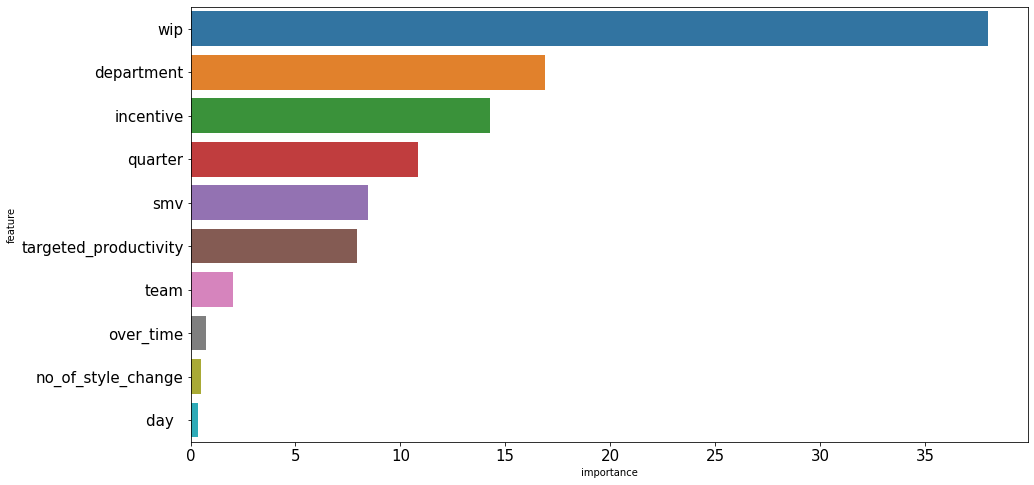

In [43]:
plt.figure(figsize = (15,8))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
sns.barplot(x = 'importance', y = 'feature', data = feature_importance_catboost, 
            order = feature_importance_catboost.sort_values('importance', ascending=False).feature)

##5th Attempt

Streaming output truncated to the last 5000 lines.
0:	learn: 0.1770055	total: 1.14ms	remaining: 1.14s
1:	learn: 0.1765986	total: 2.4ms	remaining: 1.2s
2:	learn: 0.1761986	total: 3.62ms	remaining: 1.2s
3:	learn: 0.1756847	total: 4.87ms	remaining: 1.21s
4:	learn: 0.1753621	total: 6.19ms	remaining: 1.23s
5:	learn: 0.1749568	total: 7.48ms	remaining: 1.24s
6:	learn: 0.1745763	total: 8.69ms	remaining: 1.23s
7:	learn: 0.1742641	total: 9.91ms	remaining: 1.23s
8:	learn: 0.1739655	total: 11.2ms	remaining: 1.23s
9:	learn: 0.1737628	total: 12.4ms	remaining: 1.22s
10:	learn: 0.1734208	total: 13.6ms	remaining: 1.23s
11:	learn: 0.1728210	total: 14.7ms	remaining: 1.21s
12:	learn: 0.1724765	total: 16ms	remaining: 1.21s
13:	learn: 0.1720264	total: 17.1ms	remaining: 1.21s
14:	learn: 0.1717251	total: 18.3ms	remaining: 1.2s
15:	learn: 0.1714356	total: 19.5ms	remaining: 1.2s
16:	learn: 0.1709503	total: 20.9ms	remaining: 1.21s
17:	learn: 0.1704667	total: 22.4ms	remaining: 1.22s
18:	learn: 0.1702505	total: 23

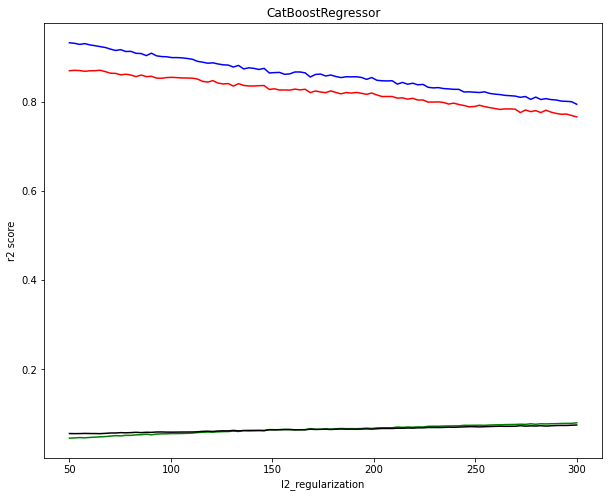

In [ ]:
l2_reg = [float(x) for x in np.linspace(50,300,num=100, endpoint=True)]
train_results = []
test_results = []
train_rmse = []
test_rmse = []
for l2 in l2_reg:
   cat = CatBoostRegressor(l2_leaf_reg= l2, random_state=42)
   cat.fit(X_train, y_train)
   train_pred = cat.predict(X_train)
   r2_train = r2_score(y_train, train_pred)
   mse_train = mean_squared_error(y_train, train_pred)
   rmse_train = np.sqrt(mean_squared_error(y_train,train_pred))
   train_results.append(r2_train)
   train_rmse.append(rmse_train)

   test_pred = cat.predict(X_test)
   mse_test =  mean_squared_error(y_test, test_pred)
   rmse_test = np.sqrt(mean_squared_error(y_test, test_pred))
   r2_test = r2_score(y_test, test_pred)
   test_results.append(r2_test)
   test_rmse.append(rmse_test)
plt.figure(figsize=(10,8))
line1, = plt.plot(l2_reg, train_results, 'b', label = 'Train r2 score')
line2, = plt.plot(l2_reg, test_results, 'r', label = 'Test r2 score')
line3, = plt.plot(l2_reg, train_rmse, 'g', label = 'train_rmse')
line4, = plt.plot(l2_reg, test_rmse, 'black', label = 'test_rmse')
plt.ylabel('r2 score')
plt.xlabel('l2_regularization')
plt.title('CatBoostRegressor')
plt.show()


Streaming output truncated to the last 5000 lines.
0:	learn: 0.1768397	total: 1.07ms	remaining: 1.07s
1:	learn: 0.1763447	total: 2.36ms	remaining: 1.18s
2:	learn: 0.1758259	total: 3.58ms	remaining: 1.19s
3:	learn: 0.1753105	total: 4.77ms	remaining: 1.19s
4:	learn: 0.1747579	total: 5.93ms	remaining: 1.18s
5:	learn: 0.1742220	total: 7.11ms	remaining: 1.18s
6:	learn: 0.1736726	total: 8.28ms	remaining: 1.17s
7:	learn: 0.1731945	total: 9.47ms	remaining: 1.17s
8:	learn: 0.1727164	total: 10.6ms	remaining: 1.17s
9:	learn: 0.1721893	total: 11.8ms	remaining: 1.17s
10:	learn: 0.1716902	total: 13.1ms	remaining: 1.17s
11:	learn: 0.1711038	total: 14.3ms	remaining: 1.17s
12:	learn: 0.1706443	total: 15.4ms	remaining: 1.17s
13:	learn: 0.1701686	total: 16.5ms	remaining: 1.17s
14:	learn: 0.1697387	total: 17.7ms	remaining: 1.16s
15:	learn: 0.1692773	total: 18.9ms	remaining: 1.16s
16:	learn: 0.1688111	total: 20ms	remaining: 1.16s
17:	learn: 0.1684132	total: 21.2ms	remaining: 1.16s
18:	learn: 0.1679228	tota

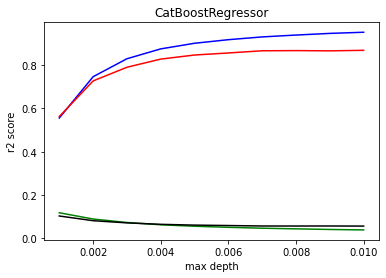

In [ ]:
learning = [float(x) for x in np.linspace(0.001,0.01,num=10, endpoint=True)]
train_results = []
test_results = []
train_rmse = []
test_rmse = []
for learning_rate in learning:
   cat = CatBoostRegressor(learning_rate = learning_rate, random_state=42)
   cat.fit(X_train, y_train)
   train_pred = cat.predict(X_train)
   r2_train = r2_score(y_train, train_pred)
   mse_train = mean_squared_error(y_train, train_pred)
   rmse_train = np.sqrt(mean_squared_error(y_train,train_pred))
   train_results.append(r2_train)
   train_rmse.append(rmse_train)

   test_pred = cat.predict(X_test)
   mse_test =  mean_squared_error(y_test, test_pred)
   rmse_test = np.sqrt(mean_squared_error(y_test, test_pred))
   r2_test = r2_score(y_test, test_pred)
   test_results.append(r2_test)
   test_rmse.append(rmse_test)

line1, = plt.plot(learning, train_results, 'b', label = 'Train r2 score')
line2, = plt.plot(learning, test_results, 'r', label = 'Test r2 score')
line3, = plt.plot(learning, train_rmse, 'g', label = 'train_rmse')
line4, = plt.plot(learning, test_rmse, 'black', label = 'test_rmse')
plt.ylabel('r2 score')
plt.xlabel('max depth')
plt.title('CatBoostRegressor')
plt.show()


Streaming output truncated to the last 5000 lines.
541:	learn: 0.1149943	total: 707ms	remaining: 951ms
542:	learn: 0.1149105	total: 708ms	remaining: 950ms
543:	learn: 0.1148230	total: 709ms	remaining: 948ms
544:	learn: 0.1147602	total: 711ms	remaining: 947ms
545:	learn: 0.1146910	total: 712ms	remaining: 945ms
546:	learn: 0.1146165	total: 713ms	remaining: 944ms
547:	learn: 0.1145616	total: 714ms	remaining: 942ms
548:	learn: 0.1144687	total: 715ms	remaining: 941ms
549:	learn: 0.1144067	total: 717ms	remaining: 939ms
550:	learn: 0.1143404	total: 718ms	remaining: 938ms
551:	learn: 0.1142652	total: 719ms	remaining: 936ms
552:	learn: 0.1142097	total: 720ms	remaining: 935ms
553:	learn: 0.1141214	total: 721ms	remaining: 934ms
554:	learn: 0.1140351	total: 723ms	remaining: 932ms
555:	learn: 0.1139505	total: 724ms	remaining: 931ms
556:	learn: 0.1138820	total: 725ms	remaining: 929ms
557:	learn: 0.1137982	total: 726ms	remaining: 928ms
558:	learn: 0.1137271	total: 727ms	remaining: 926ms
559:	learn: 0

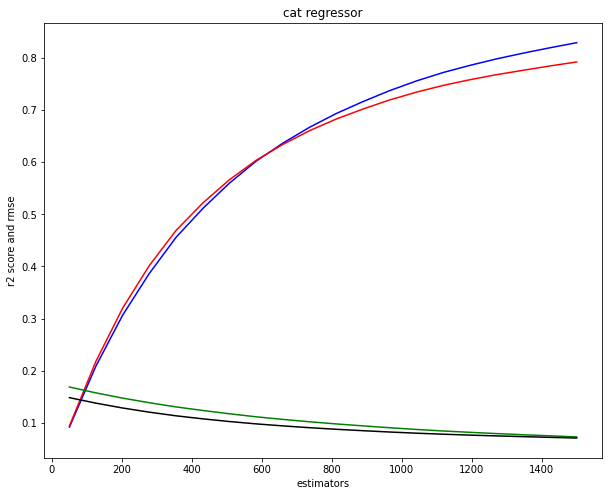

In [ ]:
est = [int(x) for x in np.linspace(50, 1500, num=20, endpoint=True)]
train_results = []
test_results = []
train_rmse = []
test_rmse = []
for n_estimators in est:
  cat = CatBoostRegressor(iterations= n_estimators, learning_rate = 0.002, random_state=42)
  cat.fit(X_train, y_train)
  train_pred = cat.predict(X_train)
  r2_train = r2_score(y_train, train_pred)
  mse_train = mean_squared_error(y_train, train_pred)
  rmse_train = np.sqrt(mean_squared_error(y_train,train_pred))
  train_results.append(r2_train)
  train_rmse.append(rmse_train)

  test_pred = cat.predict(X_test)
  mse_test =  mean_squared_error(y_test, test_pred)
  rmse_test = np.sqrt(mean_squared_error(y_test, test_pred))
  r2_test = r2_score(y_test, test_pred)
  test_results.append(r2_test)
  test_rmse.append(rmse_test)

plt.figure(figsize=(10,8))
line1, = plt.plot(est, train_results, 'b', label = 'Train r2 score')
line2, = plt.plot(est, test_results, 'r', label = 'Test r2 score')
line3, = plt.plot(est, train_rmse, 'g', label = 'train_rmse')
line4, = plt.plot(est, test_rmse, 'black', label = 'test_rmse')
plt.ylabel('r2 score and rmse')
plt.xlabel('estimators')
plt.title('cat regressor')
plt.show()

Streaming output truncated to the last 5000 lines.
4:	learn: 0.1603033	total: 30ms	remaining: 5.97s
5:	learn: 0.1571640	total: 32.7ms	remaining: 5.41s
6:	learn: 0.1541466	total: 41.5ms	remaining: 5.88s
7:	learn: 0.1515179	total: 49.2ms	remaining: 6.1s
8:	learn: 0.1485758	total: 53.5ms	remaining: 5.89s
9:	learn: 0.1454161	total: 61ms	remaining: 6.04s
10:	learn: 0.1428140	total: 69ms	remaining: 6.2s
11:	learn: 0.1401869	total: 76.8ms	remaining: 6.32s
12:	learn: 0.1375821	total: 94.7ms	remaining: 7.19s
13:	learn: 0.1354126	total: 105ms	remaining: 7.38s
14:	learn: 0.1329438	total: 112ms	remaining: 7.37s
15:	learn: 0.1304336	total: 120ms	remaining: 7.37s
16:	learn: 0.1280938	total: 127ms	remaining: 7.37s
17:	learn: 0.1259136	total: 135ms	remaining: 7.37s
18:	learn: 0.1234559	total: 143ms	remaining: 7.37s
19:	learn: 0.1214594	total: 150ms	remaining: 7.37s
20:	learn: 0.1195730	total: 158ms	remaining: 7.37s
21:	learn: 0.1175678	total: 166ms	remaining: 7.37s
22:	learn: 0.1158270	total: 174ms	re

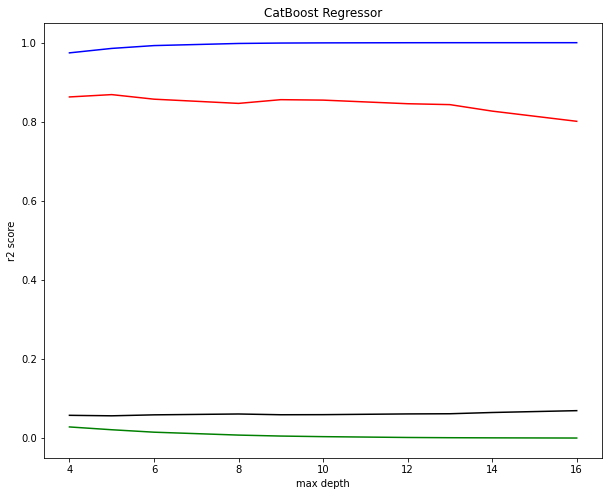

In [ ]:
depth = [int(x) for x in np.linspace(4,16,num=10, endpoint=True)]
train_results = []
test_results = []
train_rmse = []
test_rmse = []
for max_depth in depth:
   cat = CatBoostRegressor(max_depth= max_depth, random_state=42)
   cat.fit(X_train, y_train)
   train_pred = cat.predict(X_train)
   r2_train = r2_score(y_train, train_pred)
   mse_train = mean_squared_error(y_train, train_pred)
   rmse_train = np.sqrt(mean_squared_error(y_train,train_pred))
   train_results.append(r2_train)
   train_rmse.append(rmse_train)

   test_pred = cat.predict(X_test)
   mse_test =  mean_squared_error(y_test, test_pred)
   rmse_test = np.sqrt(mean_squared_error(y_test, test_pred))
   r2_test = r2_score(y_test, test_pred)
   test_results.append(r2_test)
   test_rmse.append(rmse_test)

plt.figure(figsize=(10,8))
line1, = plt.plot(depth, train_results, 'b', label = 'Train r2 score')
line2, = plt.plot(depth, test_results, 'r', label = 'Test r2 score')
line3, = plt.plot(depth, train_rmse, 'g', label = 'train_rmse')
line4, = plt.plot(depth, test_rmse, 'Black', label = 'test_rmse')
plt.ylabel('r2 score')
plt.xlabel('max depth')
plt.title('CatBoost Regressor')
plt.show()


In [ ]:
est = [int(x) for x in np.linspace(200, 1500, num=20, endpoint=True)]
depth = [int(x) for x in np.linspace(4,16,num=10, endpoint=True)]
learning = [float(x) for x in np.linspace(0.001,0.01,num=10, endpoint=True)]
l2_reg = [float(x) for x in np.linspace(50,150,num=50, endpoint=True)]

catboost = CatBoostRegressor(random_seed=42)

random_params = ({'iterations' : est,
                  'max_depth' : depth,
                  'learning_rate' : learning,
                  'l2_leaf_reg' : l2_reg,
                  'grow_policy' : ['Lossguide']})

random_search = RandomizedSearchCV(estimator= catboost, param_distributions=random_params, n_iter = 60, scoring = 'neg_mean_squared_error', cv = 5)
random_search.fit(X_train, y_train)

random_search.best_params_

Streaming output truncated to the last 5000 lines.
235:	learn: 0.1179652	total: 715ms	remaining: 1.55s
236:	learn: 0.1177642	total: 718ms	remaining: 1.54s
237:	learn: 0.1175791	total: 721ms	remaining: 1.54s
238:	learn: 0.1174593	total: 723ms	remaining: 1.54s
239:	learn: 0.1173024	total: 726ms	remaining: 1.53s
240:	learn: 0.1171491	total: 728ms	remaining: 1.53s
241:	learn: 0.1170120	total: 731ms	remaining: 1.52s
242:	learn: 0.1168621	total: 734ms	remaining: 1.52s
243:	learn: 0.1167067	total: 737ms	remaining: 1.52s
244:	learn: 0.1165801	total: 740ms	remaining: 1.51s
245:	learn: 0.1164245	total: 742ms	remaining: 1.51s
246:	learn: 0.1162553	total: 745ms	remaining: 1.51s
247:	learn: 0.1161362	total: 748ms	remaining: 1.5s
248:	learn: 0.1160307	total: 750ms	remaining: 1.5s
249:	learn: 0.1159275	total: 753ms	remaining: 1.5s
250:	learn: 0.1157890	total: 756ms	remaining: 1.49s
251:	learn: 0.1156444	total: 758ms	remaining: 1.49s
252:	learn: 0.1155070	total: 761ms	remaining: 1.49s
253:	learn: 0.11

{'grow_policy': 'Lossguide',
 'iterations': 1500,
 'l2_leaf_reg': 68.36734693877551,
 'learning_rate': 0.01,
 'max_depth': 12}

In [44]:
catboost5 = CatBoostRegressor(random_seed=42, depth = 12, iterations = 1500, l2_leaf_reg = 68.36734693877551, learning_rate = 0.01, grow_policy = 'Lossguide')
catboost5.fit(X_train, y_train)
evaluate_train(catboost5, X_train, y_train)
evaluate(catboost5, X_test, y_test)

0:	learn: 0.1767936	total: 2.85ms	remaining: 4.27s
1:	learn: 0.1762401	total: 7.57ms	remaining: 5.67s
2:	learn: 0.1757351	total: 15.7ms	remaining: 7.84s
3:	learn: 0.1752141	total: 19.9ms	remaining: 7.45s
4:	learn: 0.1745846	total: 23.9ms	remaining: 7.15s
5:	learn: 0.1740794	total: 28.3ms	remaining: 7.03s
6:	learn: 0.1736219	total: 32.2ms	remaining: 6.86s
7:	learn: 0.1732008	total: 35.7ms	remaining: 6.67s
8:	learn: 0.1727236	total: 39.9ms	remaining: 6.62s
9:	learn: 0.1721489	total: 43.5ms	remaining: 6.49s
10:	learn: 0.1716846	total: 46.9ms	remaining: 6.35s
11:	learn: 0.1711909	total: 51.2ms	remaining: 6.35s
12:	learn: 0.1707334	total: 55.1ms	remaining: 6.3s
13:	learn: 0.1702530	total: 58.7ms	remaining: 6.23s
14:	learn: 0.1697541	total: 62.5ms	remaining: 6.19s
15:	learn: 0.1691910	total: 65.9ms	remaining: 6.11s
16:	learn: 0.1686747	total: 69.2ms	remaining: 6.03s
17:	learn: 0.1681749	total: 74.6ms	remaining: 6.14s
18:	learn: 0.1677016	total: 78.1ms	remaining: 6.09s
19:	learn: 0.1673297	to

<function __main__.evaluate>

##6th attempt

In [ ]:
bins = [int(x) for x in np.linspace(50, 255, num = 75, endpoint=True)]

catboost6 = CatBoostRegressor(random_seed=42, depth = 9, iterations = 1294, l2_leaf_reg = 56.12244897959184, learning_rate = 0.008)

random_params = ({'max_bin' : bins})

random_search = RandomizedSearchCV(estimator= catboost6, param_distributions=random_params, n_iter = 60, scoring = 'neg_mean_squared_error', cv = 5)
random_search.fit(X_train, y_train)

random_search.best_params_

Streaming output truncated to the last 5000 lines.
176:	learn: 0.1425542	total: 472ms	remaining: 2.98s
177:	learn: 0.1424121	total: 474ms	remaining: 2.97s
178:	learn: 0.1423206	total: 477ms	remaining: 2.97s
179:	learn: 0.1422279	total: 480ms	remaining: 2.97s
180:	learn: 0.1420676	total: 482ms	remaining: 2.96s
181:	learn: 0.1418621	total: 483ms	remaining: 2.95s
182:	learn: 0.1417469	total: 486ms	remaining: 2.95s
183:	learn: 0.1416398	total: 489ms	remaining: 2.95s
184:	learn: 0.1415143	total: 491ms	remaining: 2.94s
185:	learn: 0.1413832	total: 495ms	remaining: 2.95s
186:	learn: 0.1412605	total: 499ms	remaining: 2.96s
187:	learn: 0.1410893	total: 502ms	remaining: 2.95s
188:	learn: 0.1409231	total: 505ms	remaining: 2.95s
189:	learn: 0.1407883	total: 506ms	remaining: 2.94s
190:	learn: 0.1406725	total: 509ms	remaining: 2.94s
191:	learn: 0.1405241	total: 511ms	remaining: 2.93s
192:	learn: 0.1403340	total: 512ms	remaining: 2.92s
193:	learn: 0.1402538	total: 515ms	remaining: 2.92s
194:	learn: 0

{'max_bin': 180}

In [45]:
catboost6 = CatBoostRegressor(random_seed=42, depth = 9, iterations = 1294, l2_leaf_reg = 28, learning_rate = 0.008, max_bin = 180, grow_policy= 'SymmetricTree',
                              random_strength = 0.75)
catboost6.fit(X_train, y_train)
evaluate_train(catboost6, X_train, y_train)
evaluate(catboost6, X_test, y_test)

0:	learn: 0.1769408	total: 2.75ms	remaining: 3.56s
1:	learn: 0.1765295	total: 7.22ms	remaining: 4.66s
2:	learn: 0.1760403	total: 8.46ms	remaining: 3.64s
3:	learn: 0.1757072	total: 12.6ms	remaining: 4.06s
4:	learn: 0.1753268	total: 16.5ms	remaining: 4.25s
5:	learn: 0.1749021	total: 20.1ms	remaining: 4.3s
6:	learn: 0.1745440	total: 23.9ms	remaining: 4.39s
7:	learn: 0.1742173	total: 28.1ms	remaining: 4.52s
8:	learn: 0.1737629	total: 29.9ms	remaining: 4.27s
9:	learn: 0.1734120	total: 33.9ms	remaining: 4.36s
10:	learn: 0.1730538	total: 37.5ms	remaining: 4.37s
11:	learn: 0.1727847	total: 41.1ms	remaining: 4.39s
12:	learn: 0.1724019	total: 44.4ms	remaining: 4.38s
13:	learn: 0.1719439	total: 45.6ms	remaining: 4.17s
14:	learn: 0.1716109	total: 52.1ms	remaining: 4.45s
15:	learn: 0.1711808	total: 55.7ms	remaining: 4.45s
16:	learn: 0.1707602	total: 59.2ms	remaining: 4.45s
17:	learn: 0.1703292	total: 63ms	remaining: 4.47s
18:	learn: 0.1698573	total: 64ms	remaining: 4.29s
19:	learn: 0.1695776	total:

<function __main__.evaluate>

In [61]:
model_comparison_table = pd.DataFrame()
model_comparison_table['model'] = ['Decision Tree Regressor1', 'Decision Tree Regressor2', 'Random Forest Regressor1', 'Random Forest Regressor2',
                                   'Gradient Boosting Regressor1', 'Gradient Boosting Regressor2', 'HistGradientBoostingRegressor1', 'HistGradientBoostingRegressor2',
                                   'CatBoostRegressor1', 'CatBoostRegressor2', 'CatBoostRegressor3', 'CatBoostRegressor4', 'CatBoostRegressor5', 'CatBoostRegressor6']

model_comparison_table['train R2 score'] = [r2_score(y_train, dtree1.predict(X_train)), r2_score(y_train, dtree2.predict(X_train)),
                                            r2_score(y_train, rf1.predict(X_train)), r2_score(y_train, rf2.predict(X_train)),
                                            r2_score(y_train, gbdt1.predict(X_train)), r2_score(y_train, gbdt2.predict(X_train)),
                                            r2_score(y_train, histgb1.predict(X_train)), r2_score(y_train, histgbm2.predict(X_train)),
                                            r2_score(y_train, catboost1.predict(X_train)), r2_score(y_train, catboost2.predict(X_train)),
                                            r2_score(y_train, catboost3.predict(X_train)), r2_score(y_train, catboost4.predict(X_train)),
                                            r2_score(y_train, catboost5.predict(X_train)), r2_score(y_train, catboost6.predict(X_train))]

model_comparison_table['validation R2 score'] = [r2_score(y_test, dtree1.predict(X_test)), r2_score(y_test, dtree2.predict(X_test)),
                                                  r2_score(y_test, rf1.predict(X_test)), r2_score(y_test, rf2.predict(X_test)),
                                                  r2_score(y_test, gbdt1.predict(X_test)), r2_score(y_test, gbdt2.predict(X_test)),
                                                  r2_score(y_test, histgb1.predict(X_test)), r2_score(y_test, histgbm2.predict(X_test)),
                                                  r2_score(y_test, catboost1.predict(X_test)), r2_score(y_test, catboost2.predict(X_test)),
                                                  r2_score(y_test, catboost3.predict(X_test)), r2_score(y_test, catboost4.predict(X_test)),
                                                  r2_score(y_test, catboost5.predict(X_test)), r2_score(y_test, catboost6.predict(X_test))]

model_comparison_table['R2 score difference'] = model_comparison_table['train R2 score'] - model_comparison_table['validation R2 score']

model_comparison_table

model  ...  R2 score difference
0         Decision Tree Regressor1  ...             0.435905
1         Decision Tree Regressor2  ...             0.011933
2         Random Forest Regressor1  ...             0.192643
3         Random Forest Regressor2  ...            -0.010516
4     Gradient Boosting Regressor1  ...             0.098976
5     Gradient Boosting Regressor2  ...             0.175339
6   HistGradientBoostingRegressor1  ...             0.154963
7   HistGradientBoostingRegressor2  ...             0.119479
8               CatBoostRegressor1  ...             0.135499
9               CatBoostRegressor2  ...             0.059941
10              CatBoostRegressor3  ...             0.058113
11              CatBoostRegressor4  ...             0.043102
12              CatBoostRegressor5  ...             0.083973
13              CatBoostRegressor6  ...             0.060609

[14 rows x 4 columns]

In [63]:
import pickle
pickle.dump(catboost4, open('catboost.pickle', 'wb'), protocol = pickle.HIGHEST_PROTOCOL)